In [1]:
import os
import numpy as np
import threading as thr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
mammo_o = []
mammo_f = []
label = []
project_folder = "../dataset/"
os.chdir(project_folder)
l = os.listdir()

In [4]:
def create_dataset(ls, o_img, f_img, lbl):
    for l in ls:
        if "_1_resized.pgm" in l:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(project_folder,l)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            lbl.append(1)
        elif "_2_resized.pgm" in l:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(project_folder,l)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            lbl.append(0)

In [5]:
os.chdir("./")
threads = []
chunk = 6
for i in range(49):
    t = thr.Thread(target = create_dataset, args = (l[i*chunk : (i+1)*chunk], mammo_o, mammo_f, label))
    threads.append(t)
    t.start()

for i in threads:
    i.join()

In [6]:
mammo_o = np.asarray(mammo_o, dtype = 'float32')/255.
mammo_f = np.asarray(mammo_f, dtype = 'float32')/255.
label = np.asarray(label)
mammo_o_4d = np.reshape(mammo_o, (147, 125, 125, 1))
print(mammo_o_4d.shape)
mammo_f_4d = np.reshape(mammo_f, (147, 64, 64, 1))
print(mammo_f_4d.shape)

(147, 125, 125, 1)
(147, 64, 64, 1)


In [7]:
def cnn_f(shape=(64, 64, 1)):
    model = Sequential([
        
        Conv2D(10, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
    
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(16, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(29, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.2),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [8]:
model_f = cnn_f()
model_f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 10)        100       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 10)       40        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 10)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 16)        1456      
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 16)       6

In [9]:
learning_rate = 0.001
model_f.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

Epoch 1/200
6/6 [==============================] - 2s 157ms/step - loss: 0.7311 - accuracy: 0.5812 - val_loss: 0.6976 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 91ms/step - loss: 0.5722 - accuracy: 0.7009 - val_loss: 0.6926 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 95ms/step - loss: 0.5156 - accuracy: 0.7350 - val_loss: 0.6882 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 92ms/step - loss: 0.4862 - accuracy: 0.7692 - val_loss: 0.6830 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 93ms/step - loss: 0.4511 - accuracy: 0.8034 - val_loss: 0.6802 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 96ms/step - loss: 0.4223 - accuracy: 0.8205 - val_loss: 0.6774 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s 98ms/step - loss: 0.4362 - 

6/6 [==============================] - 1s 101ms/step - loss: 0.2437 - accuracy: 0.9145 - val_loss: 0.9166 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 54/200
6/6 [==============================] - 1s 96ms/step - loss: 0.2327 - accuracy: 0.9231 - val_loss: 0.9223 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 55/200
6/6 [==============================] - 1s 87ms/step - loss: 0.2417 - accuracy: 0.9145 - val_loss: 0.9273 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 56/200
6/6 [==============================] - 1s 109ms/step - loss: 0.2626 - accuracy: 0.9060 - val_loss: 0.9320 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 57/200
6/6 [==============================] - 1s 86ms/step - loss: 0.2522 - accuracy: 0.9060 - val_loss: 0.9360 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 58/200
6/6 [==============================] - 0s 82ms/step - loss: 0.2454 - accuracy: 0.9145 - val_loss: 0.9401 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 59/200
6/6 [==============================] - 0s 82ms/ste

Epoch 105/200
6/6 [==============================] - 1s 107ms/step - loss: 0.2402 - accuracy: 0.9231 - val_loss: 0.9044 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 106/200
6/6 [==============================] - 1s 106ms/step - loss: 0.2417 - accuracy: 0.9402 - val_loss: 0.9027 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 107/200
6/6 [==============================] - 1s 132ms/step - loss: 0.2472 - accuracy: 0.9145 - val_loss: 0.9006 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 108/200
6/6 [==============================] - 1s 110ms/step - loss: 0.2368 - accuracy: 0.9145 - val_loss: 0.8980 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 109/200
6/6 [==============================] - 1s 135ms/step - loss: 0.2382 - accuracy: 0.9231 - val_loss: 0.8949 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 110/200
6/6 [==============================] - 1s 107ms/step - loss: 0.2391 - accuracy: 0.9145 - val_loss: 0.8920 - val_accuracy: 0.5667 - lr: 1.0000e-13
Epoch 111/200
6/6 [=====================

6/6 [==============================] - 0s 83ms/step - loss: 0.2328 - accuracy: 0.9231 - val_loss: 0.8525 - val_accuracy: 0.5667 - lr: 1.0000e-17
Epoch 157/200
6/6 [==============================] - 0s 81ms/step - loss: 0.2405 - accuracy: 0.9145 - val_loss: 0.8524 - val_accuracy: 0.5667 - lr: 1.0000e-17
Epoch 158/200
6/6 [==============================] - 1s 86ms/step - loss: 0.2460 - accuracy: 0.9231 - val_loss: 0.8526 - val_accuracy: 0.5667 - lr: 1.0000e-17
Epoch 159/200
6/6 [==============================] - 0s 82ms/step - loss: 0.2426 - accuracy: 0.9145 - val_loss: 0.8526 - val_accuracy: 0.5667 - lr: 1.0000e-17
Epoch 160/200
6/6 [==============================] - 1s 89ms/step - loss: 0.2370 - accuracy: 0.9316 - val_loss: 0.8527 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 161/200
6/6 [==============================] - 0s 81ms/step - loss: 0.2304 - accuracy: 0.9231 - val_loss: 0.8524 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 162/200
6/6 [==============================] - 0s 82ms

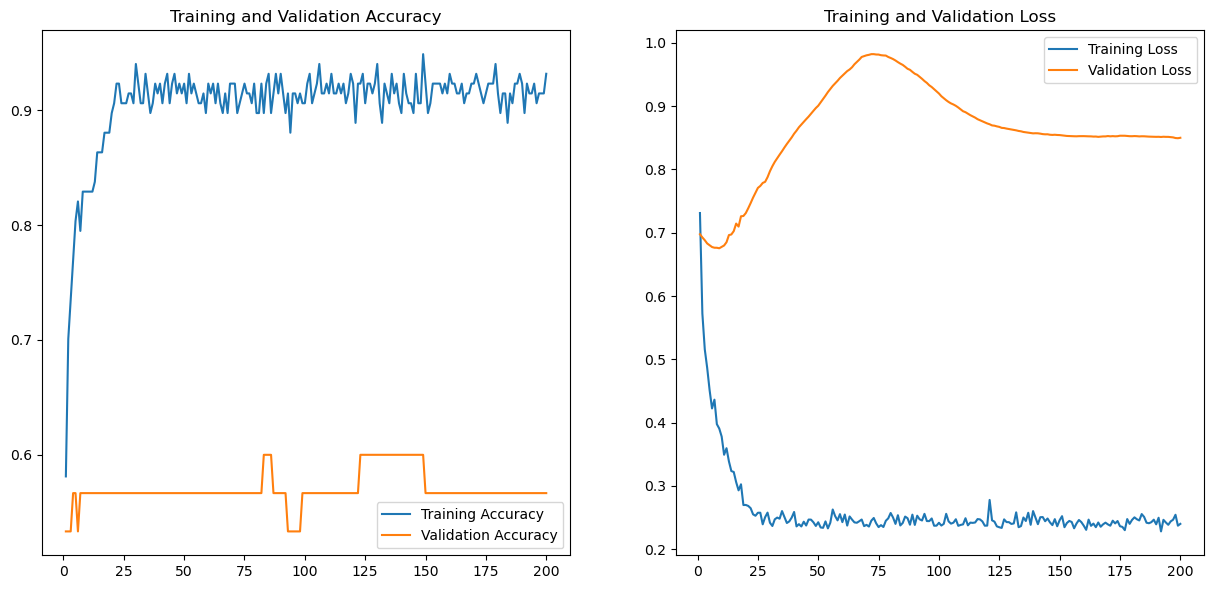

Validation accuracy: 0.567
Epoch 1/200
6/6 [==============================] - 2s 154ms/step - loss: 0.8883 - accuracy: 0.4701 - val_loss: 0.6887 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 93ms/step - loss: 0.6847 - accuracy: 0.6496 - val_loss: 0.6882 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 92ms/step - loss: 0.5455 - accuracy: 0.7692 - val_loss: 0.6804 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 91ms/step - loss: 0.4489 - accuracy: 0.8034 - val_loss: 0.6781 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 94ms/step - loss: 0.4048 - accuracy: 0.8034 - val_loss: 0.6741 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 89ms/step - loss: 0.4099 - accuracy: 0.7778 - val_loss: 0.6737 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s 

6/6 [==============================] - 0s 82ms/step - loss: 0.1776 - accuracy: 0.9658 - val_loss: 0.8161 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 54/200
6/6 [==============================] - 0s 82ms/step - loss: 0.1738 - accuracy: 0.9658 - val_loss: 0.8193 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 55/200
6/6 [==============================] - 1s 87ms/step - loss: 0.1761 - accuracy: 0.9658 - val_loss: 0.8225 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 56/200
6/6 [==============================] - 0s 82ms/step - loss: 0.1737 - accuracy: 0.9487 - val_loss: 0.8250 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 57/200
6/6 [==============================] - 0s 82ms/step - loss: 0.1713 - accuracy: 0.9658 - val_loss: 0.8274 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 58/200
6/6 [==============================] - 0s 82ms/step - loss: 0.1689 - accuracy: 0.9658 - val_loss: 0.8296 - val_accuracy: 0.6333 - lr: 1.0000e-08
Epoch 59/200
6/6 [==============================] - 0s 85ms/step 

Epoch 105/200
6/6 [==============================] - 1s 110ms/step - loss: 0.1694 - accuracy: 0.9658 - val_loss: 0.9236 - val_accuracy: 0.5333 - lr: 1.0000e-12
Epoch 106/200
6/6 [==============================] - 1s 106ms/step - loss: 0.1821 - accuracy: 0.9573 - val_loss: 0.9252 - val_accuracy: 0.5333 - lr: 1.0000e-12
Epoch 107/200
6/6 [==============================] - 1s 112ms/step - loss: 0.1765 - accuracy: 0.9658 - val_loss: 0.9262 - val_accuracy: 0.5333 - lr: 1.0000e-12
Epoch 108/200
6/6 [==============================] - 1s 130ms/step - loss: 0.1750 - accuracy: 0.9658 - val_loss: 0.9275 - val_accuracy: 0.5333 - lr: 1.0000e-13
Epoch 109/200
6/6 [==============================] - 1s 121ms/step - loss: 0.1812 - accuracy: 0.9658 - val_loss: 0.9289 - val_accuracy: 0.5333 - lr: 1.0000e-13
Epoch 110/200
6/6 [==============================] - 1s 122ms/step - loss: 0.1812 - accuracy: 0.9658 - val_loss: 0.9293 - val_accuracy: 0.5333 - lr: 1.0000e-13
Epoch 111/200
6/6 [=====================

6/6 [==============================] - 1s 102ms/step - loss: 0.1762 - accuracy: 0.9573 - val_loss: 0.9537 - val_accuracy: 0.5333 - lr: 1.0000e-17
Epoch 157/200
6/6 [==============================] - 1s 103ms/step - loss: 0.1731 - accuracy: 0.9658 - val_loss: 0.9544 - val_accuracy: 0.5333 - lr: 1.0000e-17
Epoch 158/200
6/6 [==============================] - 1s 106ms/step - loss: 0.1752 - accuracy: 0.9658 - val_loss: 0.9541 - val_accuracy: 0.5333 - lr: 1.0000e-18
Epoch 159/200
6/6 [==============================] - 1s 112ms/step - loss: 0.1751 - accuracy: 0.9658 - val_loss: 0.9543 - val_accuracy: 0.5333 - lr: 1.0000e-18
Epoch 160/200
6/6 [==============================] - 1s 100ms/step - loss: 0.1770 - accuracy: 0.9658 - val_loss: 0.9540 - val_accuracy: 0.5333 - lr: 1.0000e-18
Epoch 161/200
6/6 [==============================] - 1s 104ms/step - loss: 0.1774 - accuracy: 0.9658 - val_loss: 0.9541 - val_accuracy: 0.5333 - lr: 1.0000e-18
Epoch 162/200
6/6 [==============================] - 1

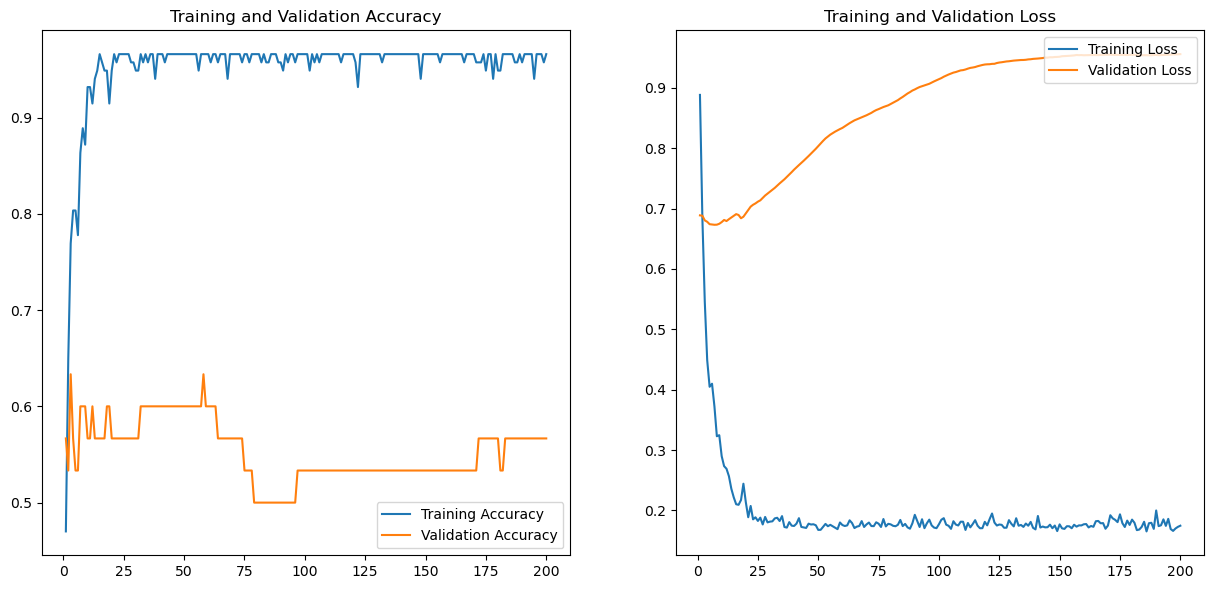

Validation accuracy: 0.567
Epoch 1/200
6/6 [==============================] - 2s 157ms/step - loss: 0.7637 - accuracy: 0.5983 - val_loss: 0.6923 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 93ms/step - loss: 0.6009 - accuracy: 0.6496 - val_loss: 0.6894 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 99ms/step - loss: 0.5424 - accuracy: 0.6752 - val_loss: 0.6818 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 97ms/step - loss: 0.4917 - accuracy: 0.7436 - val_loss: 0.6786 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 93ms/step - loss: 0.4781 - accuracy: 0.7607 - val_loss: 0.6762 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 95ms/step - loss: 0.4323 - accuracy: 0.8120 - val_loss: 0.6732 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s 

6/6 [==============================] - 1s 84ms/step - loss: 0.1425 - accuracy: 0.9658 - val_loss: 0.7806 - val_accuracy: 0.5667 - lr: 1.0000e-05
Epoch 54/200
6/6 [==============================] - 0s 81ms/step - loss: 0.1493 - accuracy: 0.9573 - val_loss: 0.7808 - val_accuracy: 0.5667 - lr: 1.0000e-06
Epoch 55/200
6/6 [==============================] - 0s 84ms/step - loss: 0.1431 - accuracy: 0.9573 - val_loss: 0.7815 - val_accuracy: 0.5667 - lr: 1.0000e-06
Epoch 56/200
6/6 [==============================] - 1s 90ms/step - loss: 0.1400 - accuracy: 0.9658 - val_loss: 0.7822 - val_accuracy: 0.5667 - lr: 1.0000e-06
Epoch 57/200
6/6 [==============================] - 1s 89ms/step - loss: 0.1323 - accuracy: 0.9658 - val_loss: 0.7828 - val_accuracy: 0.5667 - lr: 1.0000e-06
Epoch 58/200
6/6 [==============================] - 1s 90ms/step - loss: 0.1425 - accuracy: 0.9573 - val_loss: 0.7835 - val_accuracy: 0.5667 - lr: 1.0000e-06
Epoch 59/200
6/6 [==============================] - 1s 89ms/step 

Epoch 105/200
6/6 [==============================] - 1s 104ms/step - loss: 0.1454 - accuracy: 0.9573 - val_loss: 0.7805 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 106/200
6/6 [==============================] - 1s 98ms/step - loss: 0.1486 - accuracy: 0.9658 - val_loss: 0.7802 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 107/200
6/6 [==============================] - 1s 99ms/step - loss: 0.1426 - accuracy: 0.9573 - val_loss: 0.7799 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 108/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1393 - accuracy: 0.9658 - val_loss: 0.7796 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 109/200
6/6 [==============================] - 1s 108ms/step - loss: 0.1460 - accuracy: 0.9573 - val_loss: 0.7801 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 110/200
6/6 [==============================] - 1s 104ms/step - loss: 0.1534 - accuracy: 0.9744 - val_loss: 0.7797 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 111/200
6/6 [========================

6/6 [==============================] - 1s 95ms/step - loss: 0.1347 - accuracy: 0.9573 - val_loss: 0.7790 - val_accuracy: 0.6333 - lr: 1.0000e-16
Epoch 157/200
6/6 [==============================] - 1s 102ms/step - loss: 0.1459 - accuracy: 0.9744 - val_loss: 0.7792 - val_accuracy: 0.6333 - lr: 1.0000e-16
Epoch 158/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1361 - accuracy: 0.9573 - val_loss: 0.7791 - val_accuracy: 0.6333 - lr: 1.0000e-16
Epoch 159/200
6/6 [==============================] - 1s 98ms/step - loss: 0.1430 - accuracy: 0.9744 - val_loss: 0.7791 - val_accuracy: 0.6333 - lr: 1.0000e-16
Epoch 160/200
6/6 [==============================] - 1s 96ms/step - loss: 0.1505 - accuracy: 0.9573 - val_loss: 0.7792 - val_accuracy: 0.6333 - lr: 1.0000e-16
Epoch 161/200
6/6 [==============================] - 1s 98ms/step - loss: 0.1338 - accuracy: 0.9744 - val_loss: 0.7791 - val_accuracy: 0.6333 - lr: 1.0000e-16
Epoch 162/200
6/6 [==============================] - 1s 91m

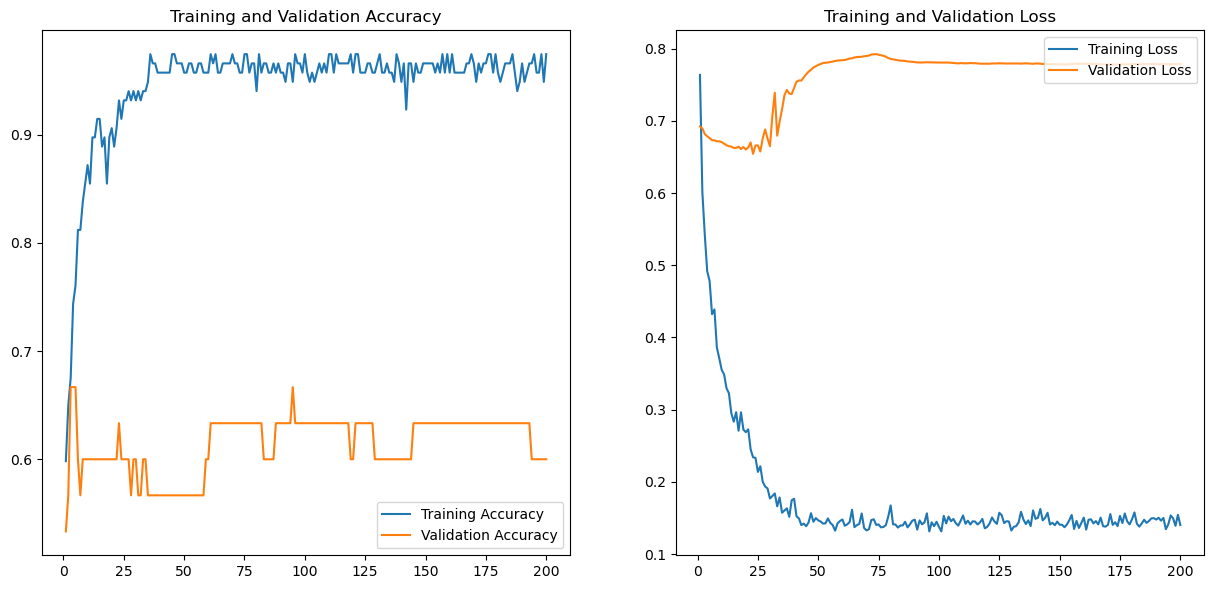

Validation accuracy: 0.600
Epoch 1/200
6/6 [==============================] - 2s 166ms/step - loss: 0.7238 - accuracy: 0.6239 - val_loss: 0.6865 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 111ms/step - loss: 0.6120 - accuracy: 0.6838 - val_loss: 0.6842 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 102ms/step - loss: 0.5419 - accuracy: 0.7265 - val_loss: 0.6795 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 99ms/step - loss: 0.4939 - accuracy: 0.7265 - val_loss: 0.6767 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 107ms/step - loss: 0.4732 - accuracy: 0.7607 - val_loss: 0.6753 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 101ms/step - loss: 0.4312 - accuracy: 0.8291 - val_loss: 0.6755 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 7/200
6/6 [==============================] -

Epoch 53/200
6/6 [==============================] - 1s 103ms/step - loss: 0.2845 - accuracy: 0.9145 - val_loss: 0.7439 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 54/200
6/6 [==============================] - 1s 99ms/step - loss: 0.2765 - accuracy: 0.9145 - val_loss: 0.7445 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 55/200
6/6 [==============================] - 1s 105ms/step - loss: 0.2814 - accuracy: 0.8974 - val_loss: 0.7454 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 56/200
6/6 [==============================] - 1s 95ms/step - loss: 0.2780 - accuracy: 0.9060 - val_loss: 0.7465 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 57/200
6/6 [==============================] - 1s 97ms/step - loss: 0.2870 - accuracy: 0.8974 - val_loss: 0.7477 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 58/200
6/6 [==============================] - 1s 111ms/step - loss: 0.2750 - accuracy: 0.9231 - val_loss: 0.7487 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 59/200
6/6 [==============================]

Epoch 105/200
6/6 [==============================] - 1s 86ms/step - loss: 0.2799 - accuracy: 0.9060 - val_loss: 0.7854 - val_accuracy: 0.5333 - lr: 1.0000e-12
Epoch 106/200
6/6 [==============================] - 1s 101ms/step - loss: 0.2810 - accuracy: 0.9060 - val_loss: 0.7862 - val_accuracy: 0.5333 - lr: 1.0000e-13
Epoch 107/200
6/6 [==============================] - 1s 96ms/step - loss: 0.2832 - accuracy: 0.8889 - val_loss: 0.7867 - val_accuracy: 0.5333 - lr: 1.0000e-13
Epoch 108/200
6/6 [==============================] - 1s 102ms/step - loss: 0.2785 - accuracy: 0.8889 - val_loss: 0.7873 - val_accuracy: 0.5333 - lr: 1.0000e-13
Epoch 109/200
6/6 [==============================] - 1s 111ms/step - loss: 0.2816 - accuracy: 0.9060 - val_loss: 0.7881 - val_accuracy: 0.5333 - lr: 1.0000e-13
Epoch 110/200
6/6 [==============================] - 1s 105ms/step - loss: 0.2884 - accuracy: 0.9060 - val_loss: 0.7886 - val_accuracy: 0.5333 - lr: 1.0000e-13
Epoch 111/200
6/6 [=======================

6/6 [==============================] - 1s 112ms/step - loss: 0.2721 - accuracy: 0.8974 - val_loss: 0.7982 - val_accuracy: 0.5333 - lr: 1.0000e-18
Epoch 157/200
6/6 [==============================] - 1s 112ms/step - loss: 0.2921 - accuracy: 0.8974 - val_loss: 0.7981 - val_accuracy: 0.5333 - lr: 1.0000e-18
Epoch 158/200
6/6 [==============================] - 1s 100ms/step - loss: 0.2796 - accuracy: 0.9060 - val_loss: 0.7978 - val_accuracy: 0.5333 - lr: 1.0000e-18
Epoch 159/200
6/6 [==============================] - 1s 98ms/step - loss: 0.2794 - accuracy: 0.8974 - val_loss: 0.7979 - val_accuracy: 0.5333 - lr: 1.0000e-18
Epoch 160/200
6/6 [==============================] - 1s 98ms/step - loss: 0.2932 - accuracy: 0.9145 - val_loss: 0.7980 - val_accuracy: 0.5333 - lr: 1.0000e-18
Epoch 161/200
6/6 [==============================] - 1s 92ms/step - loss: 0.2784 - accuracy: 0.8974 - val_loss: 0.7979 - val_accuracy: 0.5333 - lr: 1.0000e-18
Epoch 162/200
6/6 [==============================] - 1s 1

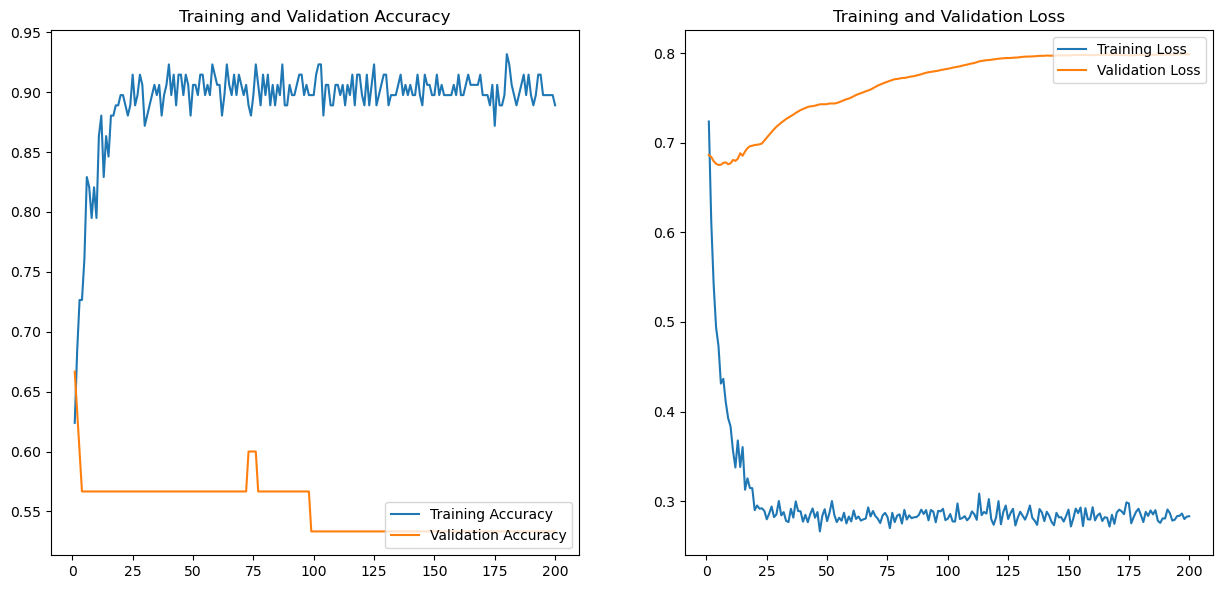

Validation accuracy: 0.533
Epoch 1/200
6/6 [==============================] - 3s 219ms/step - loss: 0.9377 - accuracy: 0.5214 - val_loss: 0.6891 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 93ms/step - loss: 0.6524 - accuracy: 0.6752 - val_loss: 0.6934 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 94ms/step - loss: 0.6269 - accuracy: 0.6325 - val_loss: 0.6898 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 93ms/step - loss: 0.4473 - accuracy: 0.7863 - val_loss: 0.6892 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 95ms/step - loss: 0.4001 - accuracy: 0.8034 - val_loss: 0.6832 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 98ms/step - loss: 0.3358 - accuracy: 0.8462 - val_loss: 0.6835 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s 

6/6 [==============================] - 0s 84ms/step - loss: 0.1099 - accuracy: 0.9829 - val_loss: 1.1588 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 54/200
6/6 [==============================] - 0s 81ms/step - loss: 0.1184 - accuracy: 0.9744 - val_loss: 1.1576 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 55/200
6/6 [==============================] - 0s 83ms/step - loss: 0.1141 - accuracy: 0.9829 - val_loss: 1.1549 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 56/200
6/6 [==============================] - 0s 83ms/step - loss: 0.1201 - accuracy: 0.9829 - val_loss: 1.1521 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 57/200
6/6 [==============================] - 0s 83ms/step - loss: 0.1276 - accuracy: 0.9658 - val_loss: 1.1483 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 58/200
6/6 [==============================] - 0s 83ms/step - loss: 0.1187 - accuracy: 0.9744 - val_loss: 1.1443 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 59/200
6/6 [==============================] - 0s 83ms/step 

Epoch 105/200
6/6 [==============================] - 1s 88ms/step - loss: 0.1185 - accuracy: 0.9829 - val_loss: 0.9431 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 106/200
6/6 [==============================] - 1s 100ms/step - loss: 0.1176 - accuracy: 0.9915 - val_loss: 0.9433 - val_accuracy: 0.6000 - lr: 1.0000e-13
Epoch 107/200
6/6 [==============================] - 1s 96ms/step - loss: 0.1243 - accuracy: 0.9744 - val_loss: 0.9429 - val_accuracy: 0.6000 - lr: 1.0000e-13
Epoch 108/200
6/6 [==============================] - 1s 106ms/step - loss: 0.1165 - accuracy: 0.9744 - val_loss: 0.9433 - val_accuracy: 0.6000 - lr: 1.0000e-13
Epoch 109/200
6/6 [==============================] - 1s 98ms/step - loss: 0.1182 - accuracy: 0.9744 - val_loss: 0.9436 - val_accuracy: 0.5667 - lr: 1.0000e-13
Epoch 110/200
6/6 [==============================] - 1s 95ms/step - loss: 0.1225 - accuracy: 0.9744 - val_loss: 0.9443 - val_accuracy: 0.5667 - lr: 1.0000e-13
Epoch 111/200
6/6 [=========================

6/6 [==============================] - 1s 94ms/step - loss: 0.1209 - accuracy: 0.9829 - val_loss: 0.9588 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 157/200
6/6 [==============================] - 1s 99ms/step - loss: 0.1165 - accuracy: 0.9744 - val_loss: 0.9588 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 158/200
6/6 [==============================] - 1s 103ms/step - loss: 0.1326 - accuracy: 0.9658 - val_loss: 0.9587 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 159/200
6/6 [==============================] - 1s 101ms/step - loss: 0.1114 - accuracy: 0.9829 - val_loss: 0.9589 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 160/200
6/6 [==============================] - 1s 99ms/step - loss: 0.1125 - accuracy: 0.9829 - val_loss: 0.9588 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 161/200
6/6 [==============================] - 1s 104ms/step - loss: 0.1156 - accuracy: 0.9744 - val_loss: 0.9580 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 162/200
6/6 [==============================] - 1s 9

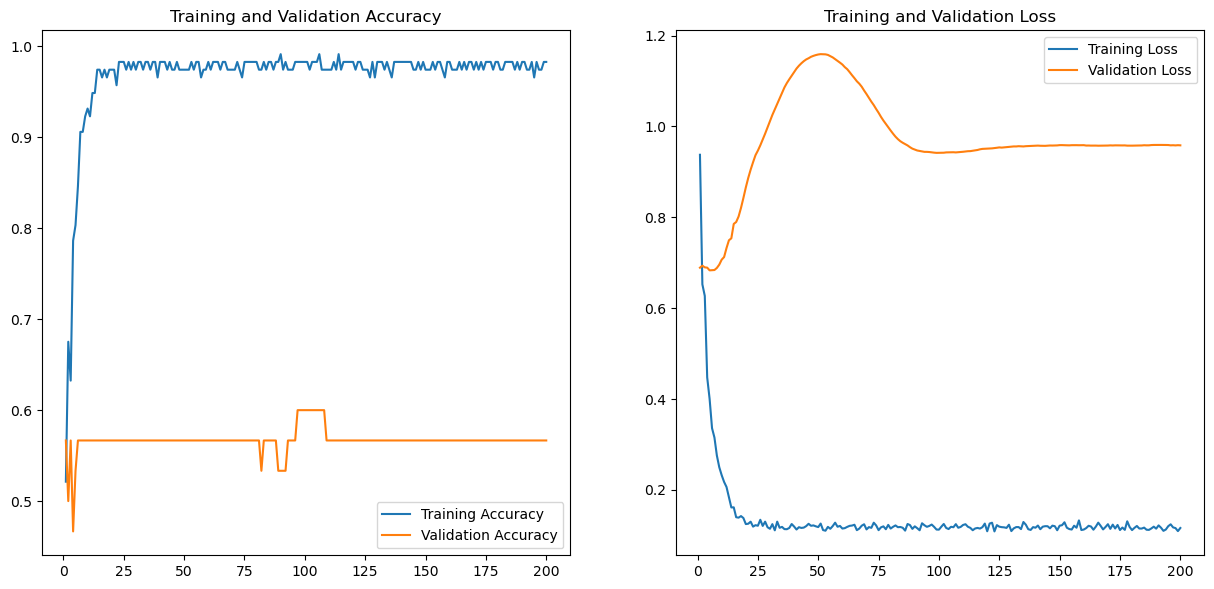

Validation accuracy: 0.567
Epoch 1/200
6/6 [==============================] - 2s 146ms/step - loss: 0.6974 - accuracy: 0.6325 - val_loss: 0.6937 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 92ms/step - loss: 0.5733 - accuracy: 0.7350 - val_loss: 0.6947 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 92ms/step - loss: 0.4778 - accuracy: 0.7949 - val_loss: 0.6880 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 99ms/step - loss: 0.4736 - accuracy: 0.7863 - val_loss: 0.6837 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 89ms/step - loss: 0.4287 - accuracy: 0.8034 - val_loss: 0.6812 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 100ms/step - loss: 0.4076 - accuracy: 0.8291 - val_loss: 0.6753 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s

6/6 [==============================] - 1s 97ms/step - loss: 0.1863 - accuracy: 0.9402 - val_loss: 0.6449 - val_accuracy: 0.6667 - lr: 1.0000e-06
Epoch 54/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1822 - accuracy: 0.9402 - val_loss: 0.6437 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 55/200
6/6 [==============================] - 1s 96ms/step - loss: 0.1954 - accuracy: 0.9402 - val_loss: 0.6426 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 56/200
6/6 [==============================] - 1s 92ms/step - loss: 0.1924 - accuracy: 0.9316 - val_loss: 0.6416 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 57/200
6/6 [==============================] - 1s 95ms/step - loss: 0.1866 - accuracy: 0.9487 - val_loss: 0.6405 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 58/200
6/6 [==============================] - 1s 95ms/step - loss: 0.1973 - accuracy: 0.9402 - val_loss: 0.6392 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 59/200
6/6 [==============================] - 1s 95ms/step 

Epoch 105/200
6/6 [==============================] - 0s 83ms/step - loss: 0.1915 - accuracy: 0.9573 - val_loss: 0.7033 - val_accuracy: 0.6667 - lr: 1.0000e-09
Epoch 106/200
6/6 [==============================] - 0s 82ms/step - loss: 0.1852 - accuracy: 0.9487 - val_loss: 0.7052 - val_accuracy: 0.6667 - lr: 1.0000e-10
Epoch 107/200
6/6 [==============================] - 0s 84ms/step - loss: 0.1877 - accuracy: 0.9487 - val_loss: 0.7071 - val_accuracy: 0.6667 - lr: 1.0000e-10
Epoch 108/200
6/6 [==============================] - 1s 87ms/step - loss: 0.1899 - accuracy: 0.9487 - val_loss: 0.7089 - val_accuracy: 0.6667 - lr: 1.0000e-10
Epoch 109/200
6/6 [==============================] - 1s 86ms/step - loss: 0.1823 - accuracy: 0.9573 - val_loss: 0.7106 - val_accuracy: 0.6667 - lr: 1.0000e-10
Epoch 110/200
6/6 [==============================] - 0s 81ms/step - loss: 0.1858 - accuracy: 0.9573 - val_loss: 0.7124 - val_accuracy: 0.6667 - lr: 1.0000e-10
Epoch 111/200
6/6 [===========================

6/6 [==============================] - 1s 96ms/step - loss: 0.1826 - accuracy: 0.9573 - val_loss: 0.7450 - val_accuracy: 0.6667 - lr: 1.0000e-15
Epoch 157/200
6/6 [==============================] - 1s 98ms/step - loss: 0.1945 - accuracy: 0.9316 - val_loss: 0.7448 - val_accuracy: 0.6667 - lr: 1.0000e-15
Epoch 158/200
6/6 [==============================] - 1s 99ms/step - loss: 0.1895 - accuracy: 0.9487 - val_loss: 0.7449 - val_accuracy: 0.6667 - lr: 1.0000e-15
Epoch 159/200
6/6 [==============================] - 1s 95ms/step - loss: 0.1879 - accuracy: 0.9487 - val_loss: 0.7453 - val_accuracy: 0.6667 - lr: 1.0000e-15
Epoch 160/200
6/6 [==============================] - 1s 93ms/step - loss: 0.1985 - accuracy: 0.9487 - val_loss: 0.7452 - val_accuracy: 0.6667 - lr: 1.0000e-15
Epoch 161/200
6/6 [==============================] - 1s 99ms/step - loss: 0.1847 - accuracy: 0.9487 - val_loss: 0.7455 - val_accuracy: 0.6667 - lr: 1.0000e-15
Epoch 162/200
6/6 [==============================] - 1s 93ms

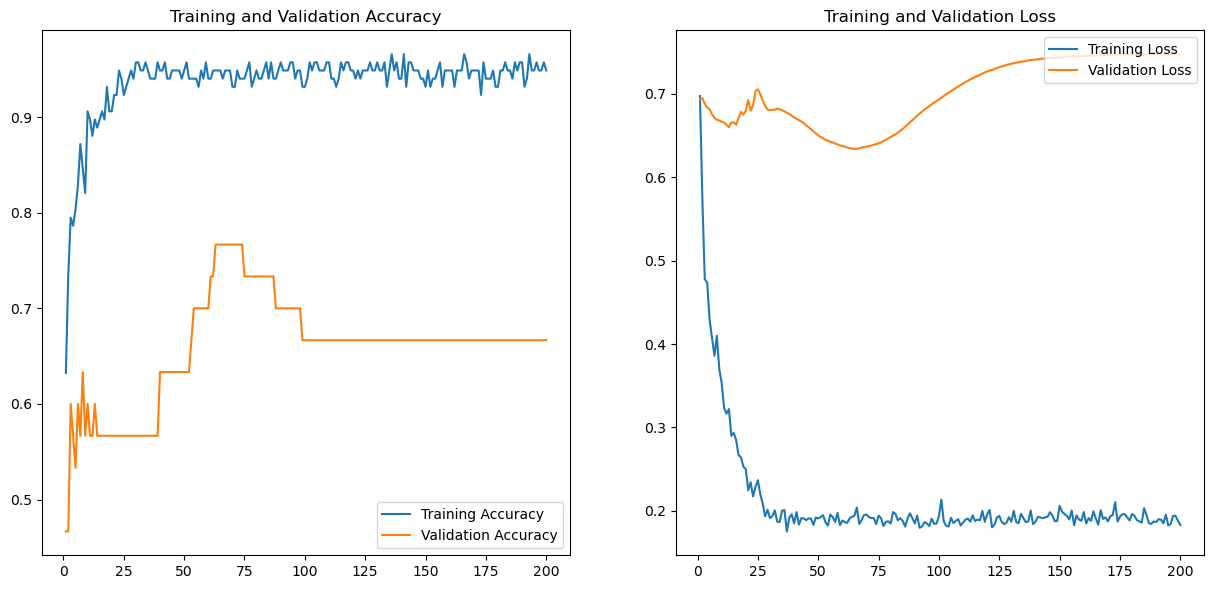

Validation accuracy: 0.667
Epoch 1/200
6/6 [==============================] - 2s 135ms/step - loss: 0.6885 - accuracy: 0.6239 - val_loss: 0.6950 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 0s 83ms/step - loss: 0.5124 - accuracy: 0.7521 - val_loss: 0.6888 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 0s 83ms/step - loss: 0.5377 - accuracy: 0.7265 - val_loss: 0.6783 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 0s 82ms/step - loss: 0.4982 - accuracy: 0.7436 - val_loss: 0.6761 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 0s 83ms/step - loss: 0.4405 - accuracy: 0.7778 - val_loss: 0.6713 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 0s 83ms/step - loss: 0.4099 - accuracy: 0.8120 - val_loss: 0.6707 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 0s 

6/6 [==============================] - 1s 103ms/step - loss: 0.1960 - accuracy: 0.9487 - val_loss: 1.1187 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 54/200
6/6 [==============================] - 1s 107ms/step - loss: 0.1951 - accuracy: 0.9487 - val_loss: 1.1253 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 55/200
6/6 [==============================] - 1s 110ms/step - loss: 0.1921 - accuracy: 0.9487 - val_loss: 1.1309 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 56/200
6/6 [==============================] - 1s 109ms/step - loss: 0.2099 - accuracy: 0.9487 - val_loss: 1.1361 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 57/200
6/6 [==============================] - 1s 112ms/step - loss: 0.1983 - accuracy: 0.9487 - val_loss: 1.1401 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 58/200
6/6 [==============================] - 1s 116ms/step - loss: 0.2076 - accuracy: 0.9487 - val_loss: 1.1413 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 59/200
6/6 [==============================] - 1s 110m

Epoch 105/200
6/6 [==============================] - 0s 82ms/step - loss: 0.2055 - accuracy: 0.9316 - val_loss: 0.8028 - val_accuracy: 0.6667 - lr: 1.0000e-12
Epoch 106/200
6/6 [==============================] - 1s 85ms/step - loss: 0.2058 - accuracy: 0.9402 - val_loss: 0.7987 - val_accuracy: 0.6667 - lr: 1.0000e-12
Epoch 107/200
6/6 [==============================] - 0s 82ms/step - loss: 0.1935 - accuracy: 0.9573 - val_loss: 0.7950 - val_accuracy: 0.6667 - lr: 1.0000e-13
Epoch 108/200
6/6 [==============================] - 0s 85ms/step - loss: 0.1973 - accuracy: 0.9573 - val_loss: 0.7919 - val_accuracy: 0.6667 - lr: 1.0000e-13
Epoch 109/200
6/6 [==============================] - 0s 82ms/step - loss: 0.1938 - accuracy: 0.9402 - val_loss: 0.7885 - val_accuracy: 0.6667 - lr: 1.0000e-13
Epoch 110/200
6/6 [==============================] - 0s 85ms/step - loss: 0.1909 - accuracy: 0.9658 - val_loss: 0.7850 - val_accuracy: 0.6667 - lr: 1.0000e-13
Epoch 111/200
6/6 [===========================

6/6 [==============================] - 1s 114ms/step - loss: 0.1925 - accuracy: 0.9573 - val_loss: 0.7483 - val_accuracy: 0.6000 - lr: 1.0000e-17
Epoch 157/200
6/6 [==============================] - 1s 114ms/step - loss: 0.2128 - accuracy: 0.9487 - val_loss: 0.7481 - val_accuracy: 0.6000 - lr: 1.0000e-18
Epoch 158/200
6/6 [==============================] - 1s 129ms/step - loss: 0.2005 - accuracy: 0.9402 - val_loss: 0.7478 - val_accuracy: 0.6000 - lr: 1.0000e-18
Epoch 159/200
6/6 [==============================] - 1s 120ms/step - loss: 0.2045 - accuracy: 0.9487 - val_loss: 0.7478 - val_accuracy: 0.6000 - lr: 1.0000e-18
Epoch 160/200
6/6 [==============================] - 1s 124ms/step - loss: 0.2082 - accuracy: 0.9487 - val_loss: 0.7476 - val_accuracy: 0.6000 - lr: 1.0000e-18
Epoch 161/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1925 - accuracy: 0.9573 - val_loss: 0.7473 - val_accuracy: 0.6000 - lr: 1.0000e-18
Epoch 162/200
6/6 [==============================] - 1s

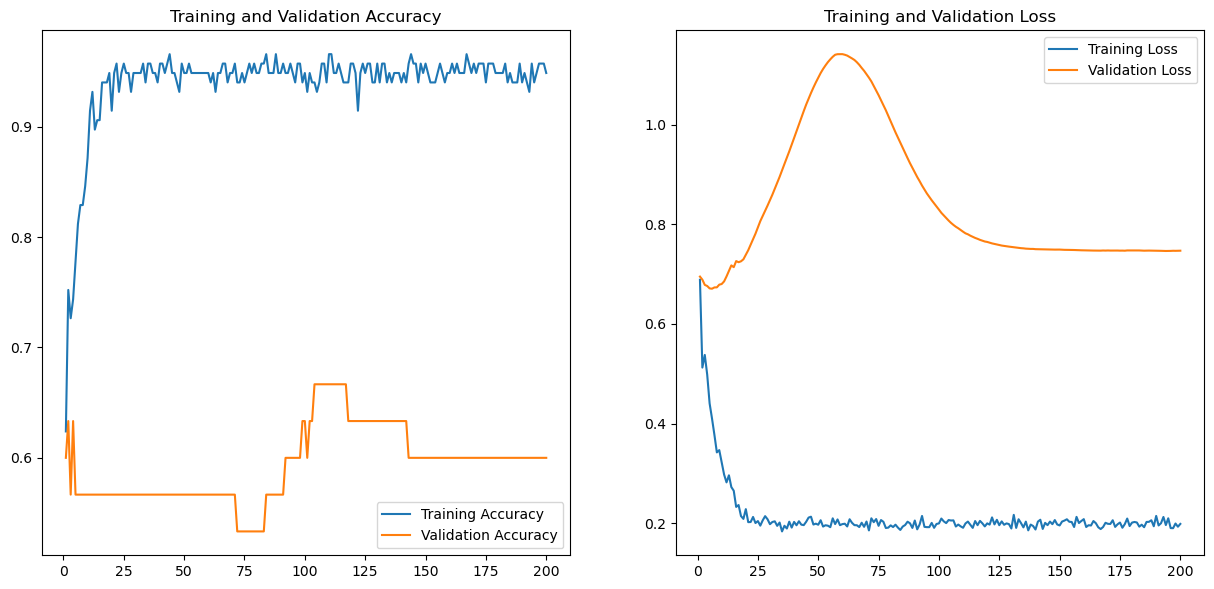

Validation accuracy: 0.600
Epoch 1/200
6/6 [==============================] - 2s 130ms/step - loss: 0.9143 - accuracy: 0.3419 - val_loss: 0.6939 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 0s 85ms/step - loss: 0.6678 - accuracy: 0.6154 - val_loss: 0.6914 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 0s 83ms/step - loss: 0.6019 - accuracy: 0.6838 - val_loss: 0.6884 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 85ms/step - loss: 0.5570 - accuracy: 0.6581 - val_loss: 0.6849 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 0s 80ms/step - loss: 0.5331 - accuracy: 0.6667 - val_loss: 0.6820 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 88ms/step - loss: 0.5155 - accuracy: 0.6752 - val_loss: 0.6812 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 0s 

6/6 [==============================] - 1s 92ms/step - loss: 0.3048 - accuracy: 0.8889 - val_loss: 0.7826 - val_accuracy: 0.5667 - lr: 1.0000e-06
Epoch 54/200
6/6 [==============================] - 1s 102ms/step - loss: 0.2972 - accuracy: 0.8974 - val_loss: 0.7872 - val_accuracy: 0.5667 - lr: 1.0000e-06
Epoch 55/200
6/6 [==============================] - 1s 105ms/step - loss: 0.2962 - accuracy: 0.8889 - val_loss: 0.7920 - val_accuracy: 0.5667 - lr: 1.0000e-06
Epoch 56/200
6/6 [==============================] - 1s 95ms/step - loss: 0.3019 - accuracy: 0.8803 - val_loss: 0.7968 - val_accuracy: 0.5667 - lr: 1.0000e-06
Epoch 57/200
6/6 [==============================] - 1s 116ms/step - loss: 0.2905 - accuracy: 0.8974 - val_loss: 0.8017 - val_accuracy: 0.5333 - lr: 1.0000e-06
Epoch 58/200
6/6 [==============================] - 1s 114ms/step - loss: 0.2969 - accuracy: 0.8803 - val_loss: 0.8065 - val_accuracy: 0.5333 - lr: 1.0000e-06
Epoch 59/200
6/6 [==============================] - 1s 101ms/

Epoch 105/200
6/6 [==============================] - 1s 91ms/step - loss: 0.3035 - accuracy: 0.8889 - val_loss: 0.9317 - val_accuracy: 0.5667 - lr: 1.0000e-11
Epoch 106/200
6/6 [==============================] - 1s 92ms/step - loss: 0.3055 - accuracy: 0.8974 - val_loss: 0.9326 - val_accuracy: 0.5667 - lr: 1.0000e-11
Epoch 107/200
6/6 [==============================] - 1s 115ms/step - loss: 0.3042 - accuracy: 0.8889 - val_loss: 0.9336 - val_accuracy: 0.5667 - lr: 1.0000e-11
Epoch 108/200
6/6 [==============================] - 1s 101ms/step - loss: 0.3148 - accuracy: 0.8889 - val_loss: 0.9343 - val_accuracy: 0.5667 - lr: 1.0000e-11
Epoch 109/200
6/6 [==============================] - 1s 96ms/step - loss: 0.3026 - accuracy: 0.8974 - val_loss: 0.9351 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 110/200
6/6 [==============================] - 1s 94ms/step - loss: 0.2887 - accuracy: 0.8974 - val_loss: 0.9358 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 111/200
6/6 [=========================

6/6 [==============================] - 1s 105ms/step - loss: 0.3007 - accuracy: 0.8974 - val_loss: 0.9488 - val_accuracy: 0.5667 - lr: 1.0000e-16
Epoch 157/200
6/6 [==============================] - 1s 104ms/step - loss: 0.3018 - accuracy: 0.8974 - val_loss: 0.9488 - val_accuracy: 0.5667 - lr: 1.0000e-16
Epoch 158/200
6/6 [==============================] - 1s 103ms/step - loss: 0.3074 - accuracy: 0.8889 - val_loss: 0.9485 - val_accuracy: 0.5667 - lr: 1.0000e-16
Epoch 159/200
6/6 [==============================] - 1s 106ms/step - loss: 0.3011 - accuracy: 0.8889 - val_loss: 0.9488 - val_accuracy: 0.5667 - lr: 1.0000e-17
Epoch 160/200
6/6 [==============================] - 1s 91ms/step - loss: 0.3016 - accuracy: 0.8974 - val_loss: 0.9491 - val_accuracy: 0.5667 - lr: 1.0000e-17
Epoch 161/200
6/6 [==============================] - 1s 105ms/step - loss: 0.2931 - accuracy: 0.9060 - val_loss: 0.9490 - val_accuracy: 0.5667 - lr: 1.0000e-17
Epoch 162/200
6/6 [==============================] - 1s

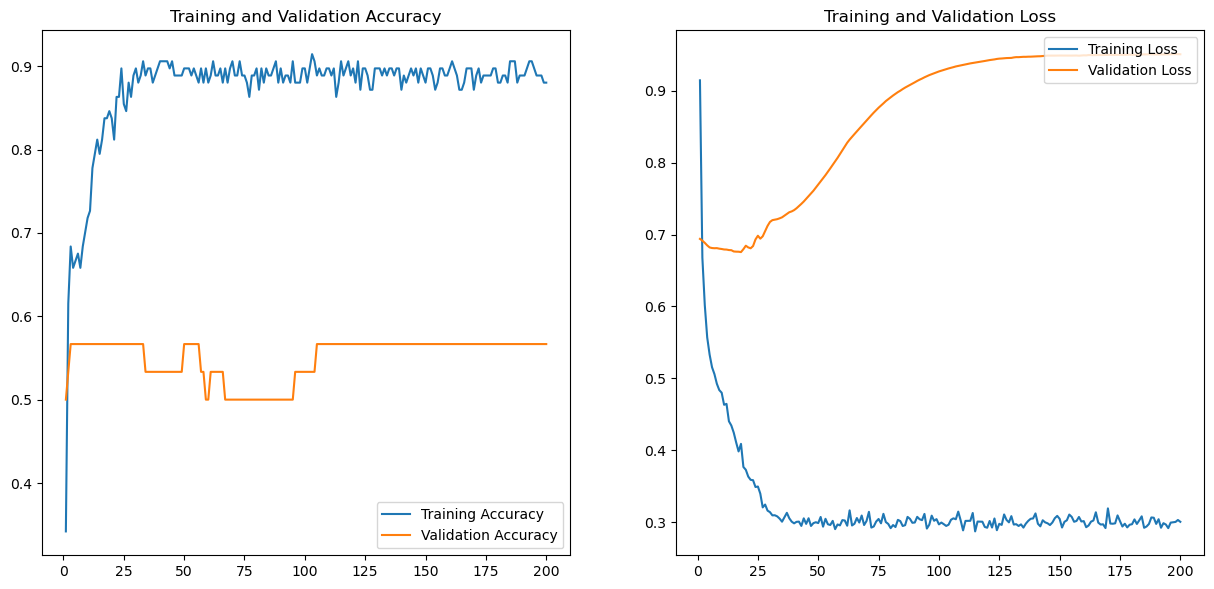

Validation accuracy: 0.567
Epoch 1/200
6/6 [==============================] - 2s 139ms/step - loss: 0.7380 - accuracy: 0.5043 - val_loss: 0.6914 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 0s 83ms/step - loss: 0.5937 - accuracy: 0.6325 - val_loss: 0.6898 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 86ms/step - loss: 0.5360 - accuracy: 0.7692 - val_loss: 0.6895 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 84ms/step - loss: 0.5057 - accuracy: 0.7692 - val_loss: 0.6873 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 97ms/step - loss: 0.4838 - accuracy: 0.8120 - val_loss: 0.6852 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 94ms/step - loss: 0.4357 - accuracy: 0.8291 - val_loss: 0.6769 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s 

6/6 [==============================] - 1s 97ms/step - loss: 0.1725 - accuracy: 0.9487 - val_loss: 0.8928 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 54/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1693 - accuracy: 0.9487 - val_loss: 0.8965 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 55/200
6/6 [==============================] - 1s 102ms/step - loss: 0.1759 - accuracy: 0.9487 - val_loss: 0.8994 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 56/200
6/6 [==============================] - 1s 98ms/step - loss: 0.1747 - accuracy: 0.9316 - val_loss: 0.9024 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 57/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1802 - accuracy: 0.9402 - val_loss: 0.9051 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 58/200
6/6 [==============================] - 1s 100ms/step - loss: 0.1805 - accuracy: 0.9402 - val_loss: 0.9085 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 59/200
6/6 [==============================] - 1s 100ms/st

Epoch 105/200
6/6 [==============================] - 1s 93ms/step - loss: 0.1749 - accuracy: 0.9402 - val_loss: 0.8852 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 106/200
6/6 [==============================] - 1s 90ms/step - loss: 0.1729 - accuracy: 0.9487 - val_loss: 0.8844 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 107/200
6/6 [==============================] - 1s 93ms/step - loss: 0.1682 - accuracy: 0.9487 - val_loss: 0.8834 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 108/200
6/6 [==============================] - 1s 90ms/step - loss: 0.1736 - accuracy: 0.9402 - val_loss: 0.8826 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 109/200
6/6 [==============================] - 1s 88ms/step - loss: 0.1713 - accuracy: 0.9402 - val_loss: 0.8820 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 110/200
6/6 [==============================] - 1s 92ms/step - loss: 0.1780 - accuracy: 0.9487 - val_loss: 0.8815 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 111/200
6/6 [===========================

6/6 [==============================] - 1s 100ms/step - loss: 0.1684 - accuracy: 0.9487 - val_loss: 0.8817 - val_accuracy: 0.6333 - lr: 1.0000e-17
Epoch 157/200
6/6 [==============================] - 1s 98ms/step - loss: 0.1700 - accuracy: 0.9487 - val_loss: 0.8816 - val_accuracy: 0.6333 - lr: 1.0000e-17
Epoch 158/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1691 - accuracy: 0.9487 - val_loss: 0.8817 - val_accuracy: 0.6333 - lr: 1.0000e-17
Epoch 159/200
6/6 [==============================] - 1s 98ms/step - loss: 0.1821 - accuracy: 0.9402 - val_loss: 0.8816 - val_accuracy: 0.6333 - lr: 1.0000e-17
Epoch 160/200
6/6 [==============================] - 1s 98ms/step - loss: 0.1758 - accuracy: 0.9487 - val_loss: 0.8820 - val_accuracy: 0.6333 - lr: 1.0000e-17
Epoch 161/200
6/6 [==============================] - 1s 93ms/step - loss: 0.1693 - accuracy: 0.9487 - val_loss: 0.8820 - val_accuracy: 0.6333 - lr: 1.0000e-18
Epoch 162/200
6/6 [==============================] - 1s 97m

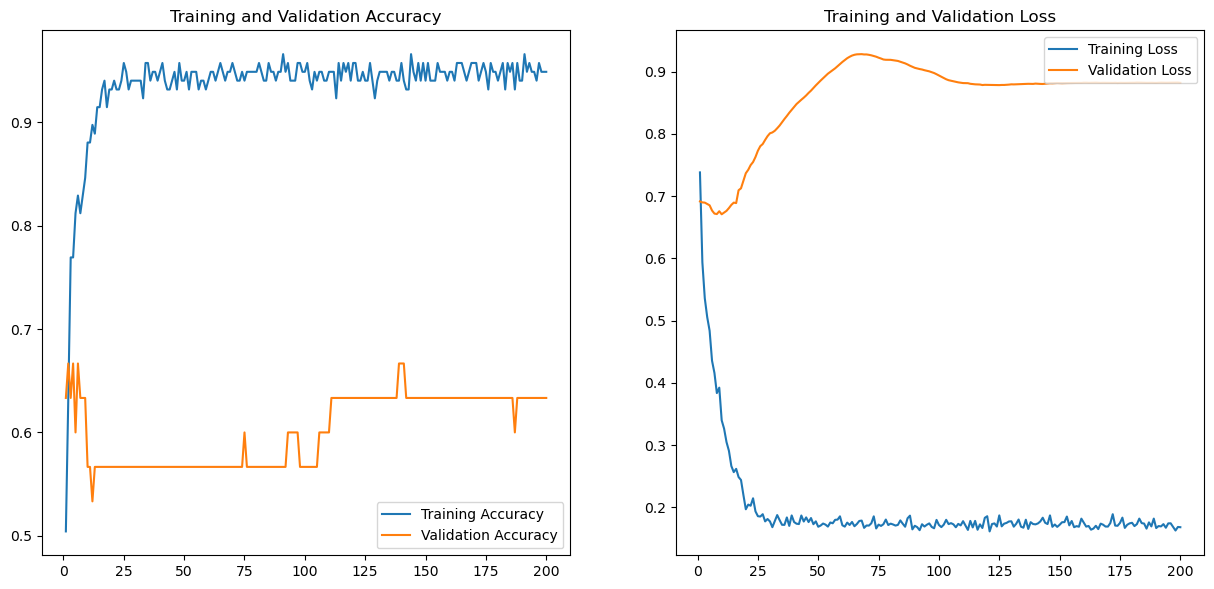

Validation accuracy: 0.633
Epoch 1/200
6/6 [==============================] - 2s 139ms/step - loss: 0.7080 - accuracy: 0.6581 - val_loss: 0.6910 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 88ms/step - loss: 0.5924 - accuracy: 0.7094 - val_loss: 0.6797 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 85ms/step - loss: 0.5103 - accuracy: 0.7521 - val_loss: 0.6760 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 0s 85ms/step - loss: 0.4528 - accuracy: 0.7949 - val_loss: 0.6759 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 86ms/step - loss: 0.4070 - accuracy: 0.8034 - val_loss: 0.6775 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 0s 84ms/step - loss: 0.3900 - accuracy: 0.8291 - val_loss: 0.6837 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s 

6/6 [==============================] - 1s 102ms/step - loss: 0.2212 - accuracy: 0.9402 - val_loss: 0.8947 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 54/200
6/6 [==============================] - 1s 97ms/step - loss: 0.2402 - accuracy: 0.9316 - val_loss: 0.8943 - val_accuracy: 0.5333 - lr: 1.0000e-07
Epoch 55/200
6/6 [==============================] - 1s 96ms/step - loss: 0.2244 - accuracy: 0.9316 - val_loss: 0.8935 - val_accuracy: 0.5333 - lr: 1.0000e-08
Epoch 56/200
6/6 [==============================] - 1s 102ms/step - loss: 0.2229 - accuracy: 0.9316 - val_loss: 0.8923 - val_accuracy: 0.5333 - lr: 1.0000e-08
Epoch 57/200
6/6 [==============================] - 1s 97ms/step - loss: 0.2287 - accuracy: 0.9231 - val_loss: 0.8908 - val_accuracy: 0.5333 - lr: 1.0000e-08
Epoch 58/200
6/6 [==============================] - 1s 101ms/step - loss: 0.2184 - accuracy: 0.9402 - val_loss: 0.8889 - val_accuracy: 0.5333 - lr: 1.0000e-08
Epoch 59/200
6/6 [==============================] - 1s 98ms/st

Epoch 105/200
6/6 [==============================] - 0s 84ms/step - loss: 0.2320 - accuracy: 0.9316 - val_loss: 0.8390 - val_accuracy: 0.6000 - lr: 1.0000e-13
Epoch 106/200
6/6 [==============================] - 1s 88ms/step - loss: 0.2198 - accuracy: 0.9316 - val_loss: 0.8397 - val_accuracy: 0.6000 - lr: 1.0000e-13
Epoch 107/200
6/6 [==============================] - 0s 84ms/step - loss: 0.2179 - accuracy: 0.9316 - val_loss: 0.8403 - val_accuracy: 0.6000 - lr: 1.0000e-13
Epoch 108/200
6/6 [==============================] - 1s 87ms/step - loss: 0.2279 - accuracy: 0.9316 - val_loss: 0.8408 - val_accuracy: 0.6000 - lr: 1.0000e-13
Epoch 109/200
6/6 [==============================] - 0s 83ms/step - loss: 0.2294 - accuracy: 0.9402 - val_loss: 0.8414 - val_accuracy: 0.6000 - lr: 1.0000e-13
Epoch 110/200
6/6 [==============================] - 1s 87ms/step - loss: 0.2170 - accuracy: 0.9402 - val_loss: 0.8416 - val_accuracy: 0.6000 - lr: 1.0000e-13
Epoch 111/200
6/6 [===========================

6/6 [==============================] - 1s 104ms/step - loss: 0.2167 - accuracy: 0.9402 - val_loss: 0.8468 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 157/200
6/6 [==============================] - 1s 115ms/step - loss: 0.2268 - accuracy: 0.9231 - val_loss: 0.8467 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 158/200
6/6 [==============================] - 1s 97ms/step - loss: 0.2336 - accuracy: 0.9231 - val_loss: 0.8468 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 159/200
6/6 [==============================] - 1s 111ms/step - loss: 0.2284 - accuracy: 0.9402 - val_loss: 0.8465 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 160/200
6/6 [==============================] - 1s 93ms/step - loss: 0.2324 - accuracy: 0.9231 - val_loss: 0.8461 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 161/200
6/6 [==============================] - 1s 102ms/step - loss: 0.2225 - accuracy: 0.9316 - val_loss: 0.8462 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 162/200
6/6 [==============================] - 1s 

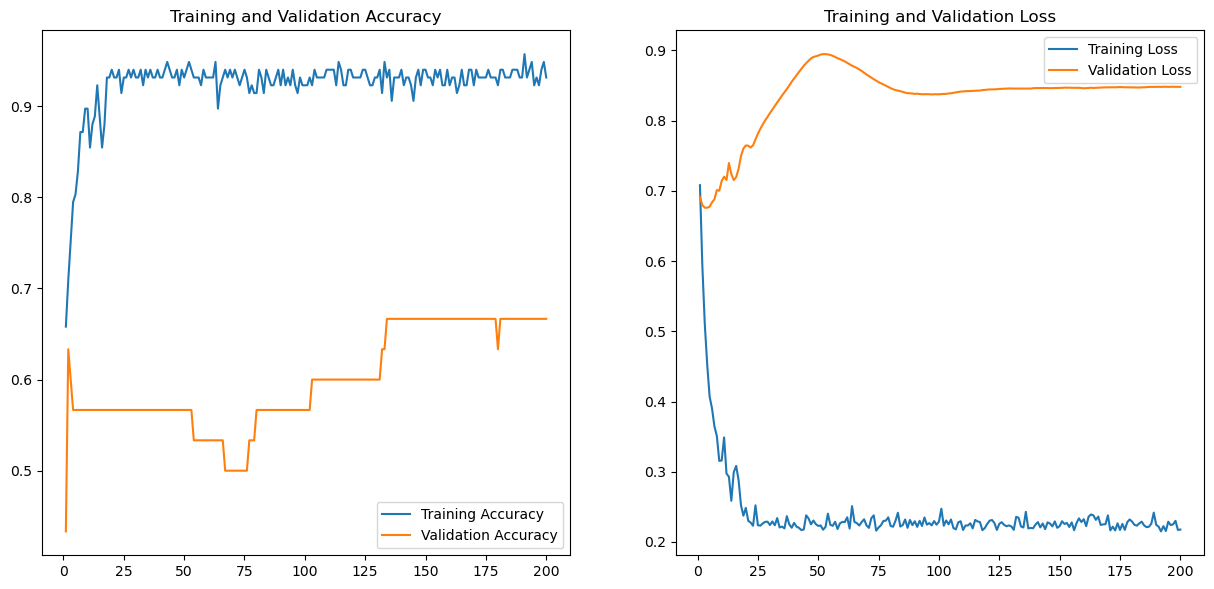

Validation accuracy: 0.667


In [12]:
X_train_f, X_val_f, Y_train_f, Y_val_f = train_test_split(mammo_f_4d, label, test_size = 0.2, random_state = 44)
batch_size = 21
acc_f = []

for i in range(10):
    model_f = cnn_f()
    learning_rate = 0.001
    model_f.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])
    train_f = model_f.fit(X_train_f, Y_train_f,
                            batch_size = batch_size,
                            epochs = 200,
                            verbose = 1,
                            validation_data = (X_val_f, Y_val_f),
                            callbacks = [reduce_on_plateau])
    acc = train_f.history['accuracy']
    val_acc = train_f.history['val_accuracy']
    loss = train_f.history['loss']
    val_loss = train_f.history['val_loss']
    
    epochs_range = range(1, len(acc)+1)
    #Train and validation accuracy 
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    #Train and validation loss 
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    _, val_acc = model_f.evaluate(X_val_f, Y_val_f, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_f.append(val_acc)

In [13]:
media_f = np.mean(acc_f)
std_f = np.std(acc_f)
print(media_f)
print(std_f)

0.5966666758060455
0.043333336481683415


In [14]:
len(acc_f)

10

In [15]:
def cnn_f_aug(shape=(64, 64, 1)):
    model = Sequential([
        
        Conv2D(9, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
    
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(22, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(33, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.2),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [16]:
model_f_aug = cnn_f_aug()
model_f_aug.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 64, 64, 9)         90        
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 9)        36        
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 64, 64, 9)         0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 31, 31, 9)        0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 31, 31, 22)        1804      
                                                                 
 batch_normalization_34 (Bat  (None, 31, 31, 22)     

In [17]:
learning_rate = 0.001
model_f_aug.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
                rotation_range = 90,
                horizontal_flip = True,
                vertical_flip = True,
                validation_split = 0.20)

aug_train_f = aug.flow(mammo_f_4d, label, batch_size = 30, subset = 'training')
aug_val_f = aug.flow(mammo_f_4d, label, batch_size = 30, subset = 'validation')

Epoch 1/200
4/4 [==============================] - 2s 317ms/step - loss: 0.6470 - accuracy: 0.5763 - val_loss: 0.6908 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 173ms/step - loss: 0.6079 - accuracy: 0.6610 - val_loss: 0.6883 - val_accuracy: 0.6207 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 185ms/step - loss: 0.6284 - accuracy: 0.6695 - val_loss: 0.6874 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5907 - accuracy: 0.6949 - val_loss: 0.6871 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5578 - accuracy: 0.7542 - val_loss: 0.6887 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5401 - accuracy: 0.7712 - val_loss: 0.6857 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/200
4/4 [==============================] - 1s 189ms/step - loss: 0.5

4/4 [==============================] - 1s 144ms/step - loss: 0.4597 - accuracy: 0.7966 - val_loss: 0.6682 - val_accuracy: 0.6207 - lr: 1.0000e-04
Epoch 54/200
4/4 [==============================] - 1s 143ms/step - loss: 0.4701 - accuracy: 0.7966 - val_loss: 0.6699 - val_accuracy: 0.6552 - lr: 1.0000e-04
Epoch 55/200
4/4 [==============================] - 1s 151ms/step - loss: 0.4597 - accuracy: 0.7797 - val_loss: 0.6961 - val_accuracy: 0.6552 - lr: 1.0000e-04
Epoch 56/200
4/4 [==============================] - 1s 141ms/step - loss: 0.4694 - accuracy: 0.8051 - val_loss: 0.6874 - val_accuracy: 0.6552 - lr: 1.0000e-04
Epoch 57/200
4/4 [==============================] - 1s 140ms/step - loss: 0.4553 - accuracy: 0.7881 - val_loss: 0.6899 - val_accuracy: 0.6552 - lr: 1.0000e-04
Epoch 58/200
4/4 [==============================] - 1s 145ms/step - loss: 0.4543 - accuracy: 0.7797 - val_loss: 0.7163 - val_accuracy: 0.6552 - lr: 1.0000e-04
Epoch 59/200
4/4 [==============================] - 1s 146m

4/4 [==============================] - 1s 213ms/step - loss: 0.4574 - accuracy: 0.8051 - val_loss: 0.7614 - val_accuracy: 0.5862 - lr: 1.0000e-08
Epoch 105/200
4/4 [==============================] - 1s 181ms/step - loss: 0.4606 - accuracy: 0.7966 - val_loss: 0.7964 - val_accuracy: 0.5517 - lr: 1.0000e-08
Epoch 106/200
4/4 [==============================] - 1s 180ms/step - loss: 0.4706 - accuracy: 0.7797 - val_loss: 0.7616 - val_accuracy: 0.5862 - lr: 1.0000e-08
Epoch 107/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4511 - accuracy: 0.8305 - val_loss: 0.7062 - val_accuracy: 0.5862 - lr: 1.0000e-09
Epoch 108/200
4/4 [==============================] - 1s 173ms/step - loss: 0.4534 - accuracy: 0.8136 - val_loss: 0.7594 - val_accuracy: 0.5862 - lr: 1.0000e-09
Epoch 109/200
4/4 [==============================] - 1s 169ms/step - loss: 0.4597 - accuracy: 0.8051 - val_loss: 0.7597 - val_accuracy: 0.5862 - lr: 1.0000e-09
Epoch 110/200
4/4 [==============================] - 1

4/4 [==============================] - 1s 142ms/step - loss: 0.4455 - accuracy: 0.8220 - val_loss: 0.7881 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 156/200
4/4 [==============================] - 1s 149ms/step - loss: 0.4468 - accuracy: 0.8051 - val_loss: 0.8152 - val_accuracy: 0.5517 - lr: 1.0000e-13
Epoch 157/200
4/4 [==============================] - 1s 147ms/step - loss: 0.4463 - accuracy: 0.8136 - val_loss: 0.8146 - val_accuracy: 0.5517 - lr: 1.0000e-14
Epoch 158/200
4/4 [==============================] - 1s 145ms/step - loss: 0.4688 - accuracy: 0.7881 - val_loss: 0.8338 - val_accuracy: 0.5172 - lr: 1.0000e-14
Epoch 159/200
4/4 [==============================] - 1s 149ms/step - loss: 0.4586 - accuracy: 0.8051 - val_loss: 0.7289 - val_accuracy: 0.5862 - lr: 1.0000e-14
Epoch 160/200
4/4 [==============================] - 1s 149ms/step - loss: 0.4493 - accuracy: 0.8051 - val_loss: 0.8073 - val_accuracy: 0.5517 - lr: 1.0000e-14
Epoch 161/200
4/4 [==============================] - 1

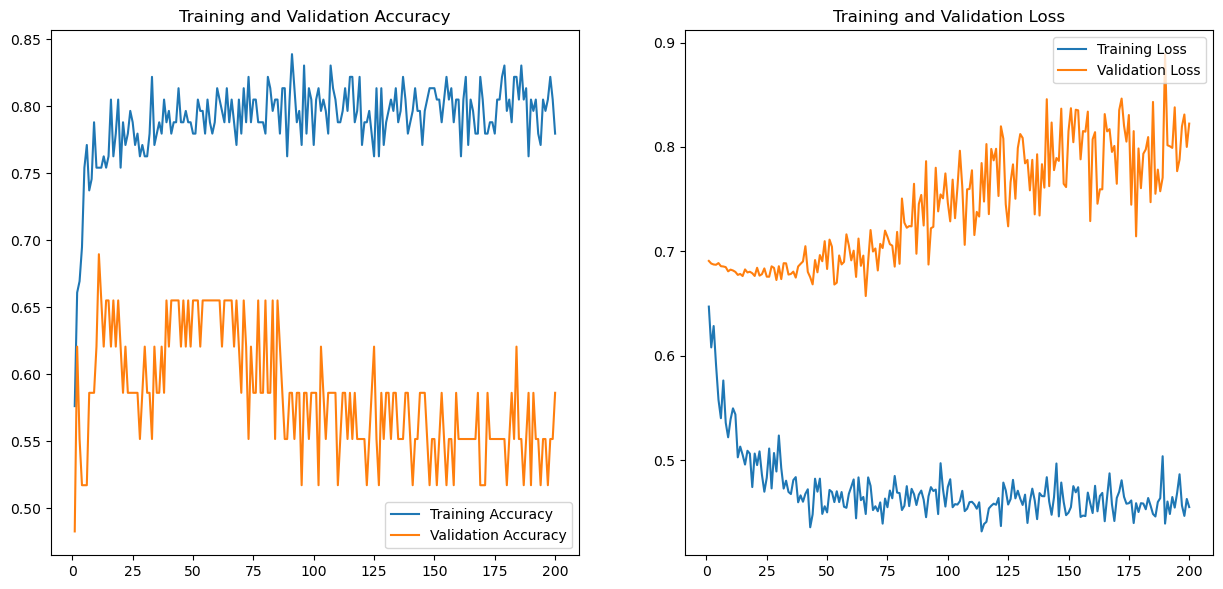

Validation accuracy: 0.586
Epoch 1/200
4/4 [==============================] - 2s 299ms/step - loss: 0.7748 - accuracy: 0.6102 - val_loss: 0.6972 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 143ms/step - loss: 0.7128 - accuracy: 0.6017 - val_loss: 0.6953 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 142ms/step - loss: 0.6413 - accuracy: 0.6441 - val_loss: 0.6949 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 142ms/step - loss: 0.6030 - accuracy: 0.6525 - val_loss: 0.6942 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 142ms/step - loss: 0.5470 - accuracy: 0.7203 - val_loss: 0.6945 - val_accuracy: 0.3793 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 143ms/step - loss: 0.6200 - accuracy: 0.7203 - val_loss: 0.6936 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/200
4/4 [==============================] 

4/4 [==============================] - 1s 145ms/step - loss: 0.4644 - accuracy: 0.8051 - val_loss: 0.6973 - val_accuracy: 0.6207 - lr: 1.0000e-04
Epoch 54/200
4/4 [==============================] - 1s 142ms/step - loss: 0.4705 - accuracy: 0.8136 - val_loss: 0.6857 - val_accuracy: 0.6897 - lr: 1.0000e-04
Epoch 55/200
4/4 [==============================] - 1s 155ms/step - loss: 0.4729 - accuracy: 0.8051 - val_loss: 0.6647 - val_accuracy: 0.6552 - lr: 1.0000e-04
Epoch 56/200
4/4 [==============================] - 1s 191ms/step - loss: 0.4601 - accuracy: 0.8051 - val_loss: 0.6956 - val_accuracy: 0.6207 - lr: 1.0000e-05
Epoch 57/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4633 - accuracy: 0.8051 - val_loss: 0.6726 - val_accuracy: 0.5862 - lr: 1.0000e-05
Epoch 58/200
4/4 [==============================] - 1s 183ms/step - loss: 0.4721 - accuracy: 0.7627 - val_loss: 0.7030 - val_accuracy: 0.6207 - lr: 1.0000e-05
Epoch 59/200
4/4 [==============================] - 1s 192m

4/4 [==============================] - 1s 146ms/step - loss: 0.4502 - accuracy: 0.7966 - val_loss: 0.7490 - val_accuracy: 0.6552 - lr: 1.0000e-09
Epoch 105/200
4/4 [==============================] - 1s 144ms/step - loss: 0.4541 - accuracy: 0.7881 - val_loss: 0.7945 - val_accuracy: 0.5862 - lr: 1.0000e-09
Epoch 106/200
4/4 [==============================] - 1s 148ms/step - loss: 0.4671 - accuracy: 0.7458 - val_loss: 0.7327 - val_accuracy: 0.6897 - lr: 1.0000e-10
Epoch 107/200
4/4 [==============================] - 1s 173ms/step - loss: 0.4598 - accuracy: 0.7797 - val_loss: 0.7061 - val_accuracy: 0.6207 - lr: 1.0000e-10
Epoch 108/200
4/4 [==============================] - 1s 172ms/step - loss: 0.4724 - accuracy: 0.8051 - val_loss: 0.7396 - val_accuracy: 0.6207 - lr: 1.0000e-10
Epoch 109/200
4/4 [==============================] - 1s 167ms/step - loss: 0.4418 - accuracy: 0.7966 - val_loss: 0.7073 - val_accuracy: 0.6897 - lr: 1.0000e-10
Epoch 110/200
4/4 [==============================] - 1

4/4 [==============================] - 1s 189ms/step - loss: 0.4535 - accuracy: 0.7881 - val_loss: 0.7911 - val_accuracy: 0.6207 - lr: 1.0000e-14
Epoch 156/200
4/4 [==============================] - 1s 184ms/step - loss: 0.4706 - accuracy: 0.7966 - val_loss: 0.6382 - val_accuracy: 0.6897 - lr: 1.0000e-15
Epoch 157/200
4/4 [==============================] - 1s 193ms/step - loss: 0.4752 - accuracy: 0.7712 - val_loss: 0.7254 - val_accuracy: 0.6207 - lr: 1.0000e-15
Epoch 158/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4352 - accuracy: 0.8051 - val_loss: 0.7816 - val_accuracy: 0.5862 - lr: 1.0000e-15
Epoch 159/200
4/4 [==============================] - 1s 174ms/step - loss: 0.4906 - accuracy: 0.7966 - val_loss: 0.6784 - val_accuracy: 0.6552 - lr: 1.0000e-15
Epoch 160/200
4/4 [==============================] - 1s 159ms/step - loss: 0.4514 - accuracy: 0.8051 - val_loss: 0.7506 - val_accuracy: 0.5862 - lr: 1.0000e-15
Epoch 161/200
4/4 [==============================] - 1

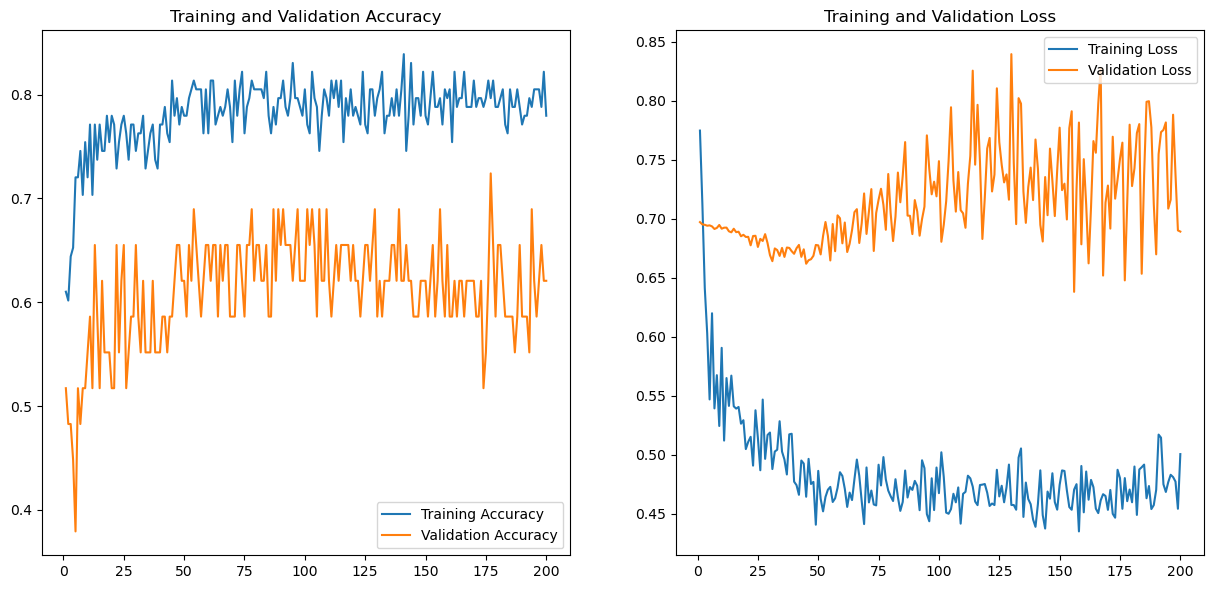

Validation accuracy: 0.586
Epoch 1/200
4/4 [==============================] - 2s 228ms/step - loss: 0.5797 - accuracy: 0.7119 - val_loss: 0.6928 - val_accuracy: 0.4138 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 140ms/step - loss: 0.6188 - accuracy: 0.7119 - val_loss: 0.6932 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 140ms/step - loss: 0.6040 - accuracy: 0.7119 - val_loss: 0.6930 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 149ms/step - loss: 0.5963 - accuracy: 0.7034 - val_loss: 0.6917 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 144ms/step - loss: 0.5621 - accuracy: 0.7458 - val_loss: 0.6910 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 151ms/step - loss: 0.5756 - accuracy: 0.7458 - val_loss: 0.6902 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 7/200
4/4 [==============================] 

4/4 [==============================] - 1s 159ms/step - loss: 0.5000 - accuracy: 0.7712 - val_loss: 0.7081 - val_accuracy: 0.5172 - lr: 1.0000e-06
Epoch 54/200
4/4 [==============================] - 1s 167ms/step - loss: 0.5104 - accuracy: 0.7288 - val_loss: 0.7148 - val_accuracy: 0.5172 - lr: 1.0000e-06
Epoch 55/200
4/4 [==============================] - 1s 159ms/step - loss: 0.5134 - accuracy: 0.7542 - val_loss: 0.7043 - val_accuracy: 0.5862 - lr: 1.0000e-07
Epoch 56/200
4/4 [==============================] - 1s 156ms/step - loss: 0.5063 - accuracy: 0.7712 - val_loss: 0.7169 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 57/200
4/4 [==============================] - 1s 167ms/step - loss: 0.5075 - accuracy: 0.8051 - val_loss: 0.7111 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 58/200
4/4 [==============================] - 1s 163ms/step - loss: 0.5002 - accuracy: 0.7712 - val_loss: 0.7099 - val_accuracy: 0.6207 - lr: 1.0000e-07
Epoch 59/200
4/4 [==============================] - 1s 156m

4/4 [==============================] - 1s 172ms/step - loss: 0.4787 - accuracy: 0.7712 - val_loss: 0.7042 - val_accuracy: 0.6207 - lr: 1.0000e-11
Epoch 105/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4816 - accuracy: 0.7712 - val_loss: 0.7516 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 106/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5112 - accuracy: 0.7542 - val_loss: 0.7261 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 107/200
4/4 [==============================] - 1s 181ms/step - loss: 0.4869 - accuracy: 0.7881 - val_loss: 0.6924 - val_accuracy: 0.6552 - lr: 1.0000e-12
Epoch 108/200
4/4 [==============================] - 1s 188ms/step - loss: 0.5191 - accuracy: 0.7627 - val_loss: 0.6940 - val_accuracy: 0.6552 - lr: 1.0000e-12
Epoch 109/200
4/4 [==============================] - 1s 179ms/step - loss: 0.5147 - accuracy: 0.7203 - val_loss: 0.6916 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 110/200
4/4 [==============================] - 1

4/4 [==============================] - 1s 163ms/step - loss: 0.5079 - accuracy: 0.7458 - val_loss: 0.6908 - val_accuracy: 0.6207 - lr: 1.0000e-15
Epoch 156/200
4/4 [==============================] - 1s 171ms/step - loss: 0.4876 - accuracy: 0.7458 - val_loss: 0.7249 - val_accuracy: 0.6207 - lr: 1.0000e-15
Epoch 157/200
4/4 [==============================] - 1s 157ms/step - loss: 0.5103 - accuracy: 0.7797 - val_loss: 0.7095 - val_accuracy: 0.6552 - lr: 1.0000e-15
Epoch 158/200
4/4 [==============================] - 1s 159ms/step - loss: 0.4973 - accuracy: 0.7627 - val_loss: 0.6675 - val_accuracy: 0.6207 - lr: 1.0000e-15
Epoch 159/200
4/4 [==============================] - 1s 168ms/step - loss: 0.4708 - accuracy: 0.8136 - val_loss: 0.7165 - val_accuracy: 0.5517 - lr: 1.0000e-15
Epoch 160/200
4/4 [==============================] - 1s 161ms/step - loss: 0.4942 - accuracy: 0.7881 - val_loss: 0.7345 - val_accuracy: 0.6207 - lr: 1.0000e-16
Epoch 161/200
4/4 [==============================] - 1

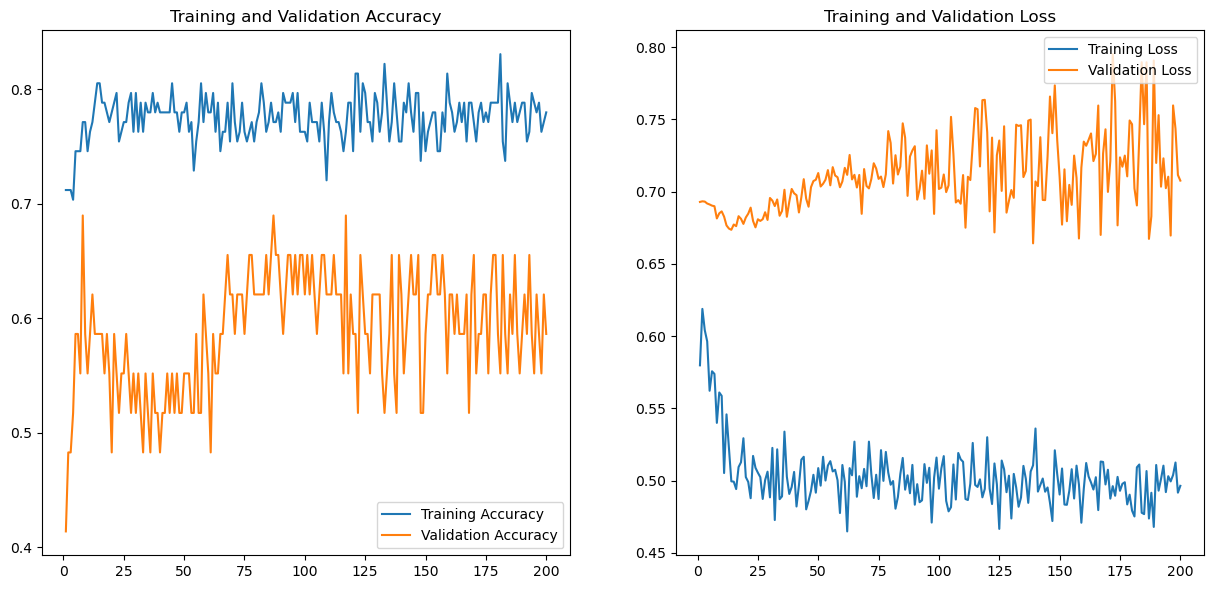

Validation accuracy: 0.586
Epoch 1/200
4/4 [==============================] - 2s 253ms/step - loss: 1.1803 - accuracy: 0.3644 - val_loss: 0.6902 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 161ms/step - loss: 0.7146 - accuracy: 0.5508 - val_loss: 0.6942 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 151ms/step - loss: 0.7007 - accuracy: 0.6610 - val_loss: 0.6936 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 162ms/step - loss: 0.6417 - accuracy: 0.6695 - val_loss: 0.6930 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 154ms/step - loss: 0.5949 - accuracy: 0.6525 - val_loss: 0.6930 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 151ms/step - loss: 0.5945 - accuracy: 0.6949 - val_loss: 0.6928 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/200
4/4 [==============================] 

4/4 [==============================] - 1s 189ms/step - loss: 0.4983 - accuracy: 0.7797 - val_loss: 0.7286 - val_accuracy: 0.5172 - lr: 1.0000e-06
Epoch 54/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5020 - accuracy: 0.7627 - val_loss: 0.7115 - val_accuracy: 0.5517 - lr: 1.0000e-06
Epoch 55/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5075 - accuracy: 0.7542 - val_loss: 0.7184 - val_accuracy: 0.5517 - lr: 1.0000e-06
Epoch 56/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4930 - accuracy: 0.7881 - val_loss: 0.7165 - val_accuracy: 0.5862 - lr: 1.0000e-06
Epoch 57/200
4/4 [==============================] - 1s 187ms/step - loss: 0.5018 - accuracy: 0.7966 - val_loss: 0.7265 - val_accuracy: 0.5517 - lr: 1.0000e-06
Epoch 58/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4855 - accuracy: 0.8051 - val_loss: 0.7301 - val_accuracy: 0.5517 - lr: 1.0000e-06
Epoch 59/200
4/4 [==============================] - 1s 185m

4/4 [==============================] - 1s 207ms/step - loss: 0.4912 - accuracy: 0.8051 - val_loss: 0.7389 - val_accuracy: 0.6207 - lr: 1.0000e-11
Epoch 105/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5109 - accuracy: 0.7458 - val_loss: 0.7448 - val_accuracy: 0.6207 - lr: 1.0000e-11
Epoch 106/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5066 - accuracy: 0.7712 - val_loss: 0.7332 - val_accuracy: 0.5862 - lr: 1.0000e-11
Epoch 107/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5031 - accuracy: 0.8051 - val_loss: 0.7280 - val_accuracy: 0.6207 - lr: 1.0000e-11
Epoch 108/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5084 - accuracy: 0.7627 - val_loss: 0.7378 - val_accuracy: 0.6552 - lr: 1.0000e-11
Epoch 109/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5034 - accuracy: 0.7627 - val_loss: 0.6783 - val_accuracy: 0.6552 - lr: 1.0000e-11
Epoch 110/200
4/4 [==============================] - 1

4/4 [==============================] - 1s 140ms/step - loss: 0.5002 - accuracy: 0.7881 - val_loss: 0.7483 - val_accuracy: 0.7241 - lr: 1.0000e-16
Epoch 156/200
4/4 [==============================] - 1s 148ms/step - loss: 0.4942 - accuracy: 0.7797 - val_loss: 0.7016 - val_accuracy: 0.5862 - lr: 1.0000e-16
Epoch 157/200
4/4 [==============================] - 1s 143ms/step - loss: 0.4925 - accuracy: 0.7712 - val_loss: 0.7116 - val_accuracy: 0.6207 - lr: 1.0000e-16
Epoch 158/200
4/4 [==============================] - 1s 148ms/step - loss: 0.4954 - accuracy: 0.7712 - val_loss: 0.6847 - val_accuracy: 0.5862 - lr: 1.0000e-16
Epoch 159/200
4/4 [==============================] - 1s 175ms/step - loss: 0.5052 - accuracy: 0.7797 - val_loss: 0.7483 - val_accuracy: 0.5862 - lr: 1.0000e-16
Epoch 160/200
4/4 [==============================] - 1s 144ms/step - loss: 0.4926 - accuracy: 0.7881 - val_loss: 0.6966 - val_accuracy: 0.5862 - lr: 1.0000e-16
Epoch 161/200
4/4 [==============================] - 1

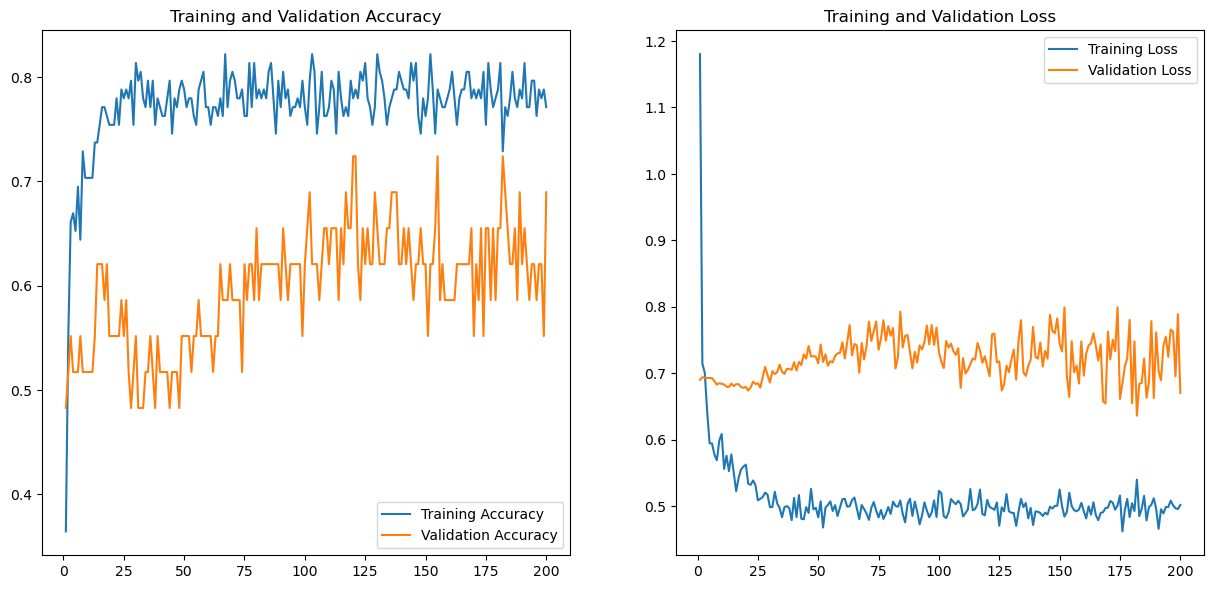

Validation accuracy: 0.621
Epoch 1/200
4/4 [==============================] - 3s 346ms/step - loss: 1.0891 - accuracy: 0.3644 - val_loss: 0.6968 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 171ms/step - loss: 0.7731 - accuracy: 0.5932 - val_loss: 0.6980 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 184ms/step - loss: 0.7868 - accuracy: 0.6525 - val_loss: 0.6987 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 169ms/step - loss: 0.7096 - accuracy: 0.6441 - val_loss: 0.6907 - val_accuracy: 0.6897 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 191ms/step - loss: 0.6482 - accuracy: 0.6949 - val_loss: 0.6889 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5921 - accuracy: 0.7288 - val_loss: 0.6936 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 7/200
4/4 [==============================] 

4/4 [==============================] - 1s 145ms/step - loss: 0.4729 - accuracy: 0.7966 - val_loss: 0.7072 - val_accuracy: 0.5517 - lr: 1.0000e-05
Epoch 54/200
4/4 [==============================] - 1s 145ms/step - loss: 0.4644 - accuracy: 0.7797 - val_loss: 0.7220 - val_accuracy: 0.5517 - lr: 1.0000e-05
Epoch 55/200
4/4 [==============================] - 1s 162ms/step - loss: 0.4853 - accuracy: 0.7627 - val_loss: 0.7129 - val_accuracy: 0.5517 - lr: 1.0000e-05
Epoch 56/200
4/4 [==============================] - 1s 142ms/step - loss: 0.4687 - accuracy: 0.7881 - val_loss: 0.7352 - val_accuracy: 0.5517 - lr: 1.0000e-05
Epoch 57/200
4/4 [==============================] - 1s 142ms/step - loss: 0.4453 - accuracy: 0.8051 - val_loss: 0.7025 - val_accuracy: 0.5862 - lr: 1.0000e-05
Epoch 58/200
4/4 [==============================] - 1s 142ms/step - loss: 0.5013 - accuracy: 0.7797 - val_loss: 0.7187 - val_accuracy: 0.5172 - lr: 1.0000e-06
Epoch 59/200
4/4 [==============================] - 1s 144m

4/4 [==============================] - 1s 161ms/step - loss: 0.4842 - accuracy: 0.7881 - val_loss: 0.7287 - val_accuracy: 0.6207 - lr: 1.0000e-10
Epoch 105/200
4/4 [==============================] - 1s 151ms/step - loss: 0.4776 - accuracy: 0.7966 - val_loss: 0.7117 - val_accuracy: 0.6207 - lr: 1.0000e-10
Epoch 106/200
4/4 [==============================] - 1s 145ms/step - loss: 0.4570 - accuracy: 0.8220 - val_loss: 0.6937 - val_accuracy: 0.6552 - lr: 1.0000e-10
Epoch 107/200
4/4 [==============================] - 1s 140ms/step - loss: 0.4801 - accuracy: 0.7881 - val_loss: 0.7157 - val_accuracy: 0.5862 - lr: 1.0000e-10
Epoch 108/200
4/4 [==============================] - 1s 156ms/step - loss: 0.4671 - accuracy: 0.7966 - val_loss: 0.7022 - val_accuracy: 0.6552 - lr: 1.0000e-11
Epoch 109/200
4/4 [==============================] - 1s 141ms/step - loss: 0.5107 - accuracy: 0.7797 - val_loss: 0.7276 - val_accuracy: 0.6552 - lr: 1.0000e-11
Epoch 110/200
4/4 [==============================] - 1

4/4 [==============================] - 1s 157ms/step - loss: 0.4793 - accuracy: 0.8051 - val_loss: 0.6776 - val_accuracy: 0.5862 - lr: 1.0000e-13
Epoch 156/200
4/4 [==============================] - 1s 158ms/step - loss: 0.4880 - accuracy: 0.7881 - val_loss: 0.7103 - val_accuracy: 0.5862 - lr: 1.0000e-13
Epoch 157/200
4/4 [==============================] - 1s 160ms/step - loss: 0.4835 - accuracy: 0.7797 - val_loss: 0.7267 - val_accuracy: 0.5862 - lr: 1.0000e-14
Epoch 158/200
4/4 [==============================] - 1s 166ms/step - loss: 0.4891 - accuracy: 0.7881 - val_loss: 0.7431 - val_accuracy: 0.5517 - lr: 1.0000e-14
Epoch 159/200
4/4 [==============================] - 1s 176ms/step - loss: 0.4568 - accuracy: 0.8305 - val_loss: 0.6763 - val_accuracy: 0.5862 - lr: 1.0000e-14
Epoch 160/200
4/4 [==============================] - 1s 172ms/step - loss: 0.4738 - accuracy: 0.8051 - val_loss: 0.6867 - val_accuracy: 0.6207 - lr: 1.0000e-14
Epoch 161/200
4/4 [==============================] - 1

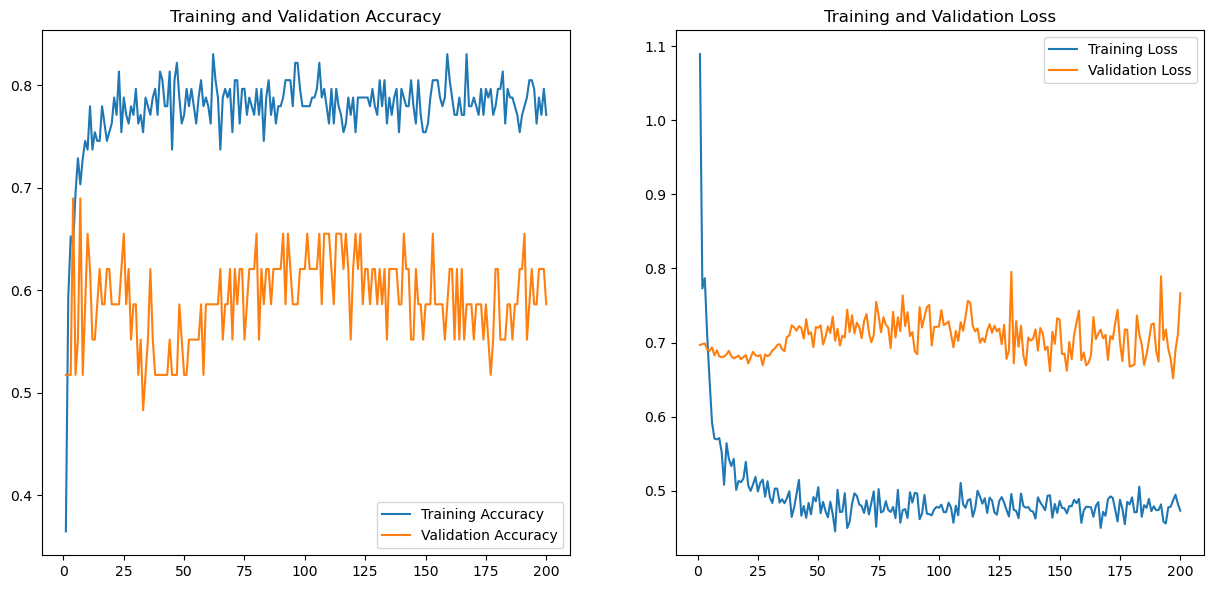

Validation accuracy: 0.552
Epoch 1/200
4/4 [==============================] - 3s 249ms/step - loss: 0.8353 - accuracy: 0.4576 - val_loss: 0.6893 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 146ms/step - loss: 0.6980 - accuracy: 0.6017 - val_loss: 0.6801 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 143ms/step - loss: 0.6279 - accuracy: 0.6695 - val_loss: 0.6825 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 175ms/step - loss: 0.5982 - accuracy: 0.6864 - val_loss: 0.6741 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5924 - accuracy: 0.7203 - val_loss: 0.6786 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 161ms/step - loss: 0.5306 - accuracy: 0.7881 - val_loss: 0.6806 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 7/200
4/4 [==============================] 

Epoch 53/200
4/4 [==============================] - 1s 172ms/step - loss: 0.4853 - accuracy: 0.7797 - val_loss: 0.6818 - val_accuracy: 0.5862 - lr: 1.0000e-06
Epoch 54/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4935 - accuracy: 0.7966 - val_loss: 0.6941 - val_accuracy: 0.5862 - lr: 1.0000e-06
Epoch 55/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5125 - accuracy: 0.7797 - val_loss: 0.6763 - val_accuracy: 0.6207 - lr: 1.0000e-06
Epoch 56/200
4/4 [==============================] - 1s 187ms/step - loss: 0.5029 - accuracy: 0.7542 - val_loss: 0.6643 - val_accuracy: 0.6552 - lr: 1.0000e-06
Epoch 57/200
4/4 [==============================] - 1s 172ms/step - loss: 0.4921 - accuracy: 0.7797 - val_loss: 0.6850 - val_accuracy: 0.6552 - lr: 1.0000e-06
Epoch 58/200
4/4 [==============================] - 1s 174ms/step - loss: 0.4959 - accuracy: 0.7881 - val_loss: 0.6751 - val_accuracy: 0.6207 - lr: 1.0000e-07
Epoch 59/200
4/4 [============================

4/4 [==============================] - 1s 177ms/step - loss: 0.5028 - accuracy: 0.7966 - val_loss: 0.7394 - val_accuracy: 0.5862 - lr: 1.0000e-10
Epoch 105/200
4/4 [==============================] - 1s 175ms/step - loss: 0.4943 - accuracy: 0.7881 - val_loss: 0.7389 - val_accuracy: 0.5517 - lr: 1.0000e-10
Epoch 106/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4756 - accuracy: 0.7966 - val_loss: 0.7564 - val_accuracy: 0.5862 - lr: 1.0000e-10
Epoch 107/200
4/4 [==============================] - 1s 167ms/step - loss: 0.4996 - accuracy: 0.7797 - val_loss: 0.7738 - val_accuracy: 0.5172 - lr: 1.0000e-10
Epoch 108/200
4/4 [==============================] - 1s 164ms/step - loss: 0.5081 - accuracy: 0.7627 - val_loss: 0.7463 - val_accuracy: 0.5517 - lr: 1.0000e-10
Epoch 109/200
4/4 [==============================] - 1s 170ms/step - loss: 0.4943 - accuracy: 0.7797 - val_loss: 0.7772 - val_accuracy: 0.5172 - lr: 1.0000e-10
Epoch 110/200
4/4 [==============================] - 1

4/4 [==============================] - 1s 203ms/step - loss: 0.4902 - accuracy: 0.7797 - val_loss: 0.7685 - val_accuracy: 0.6552 - lr: 1.0000e-15
Epoch 156/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4943 - accuracy: 0.7712 - val_loss: 0.7569 - val_accuracy: 0.6207 - lr: 1.0000e-15
Epoch 157/200
4/4 [==============================] - 1s 193ms/step - loss: 0.4955 - accuracy: 0.7881 - val_loss: 0.6761 - val_accuracy: 0.6207 - lr: 1.0000e-15
Epoch 158/200
4/4 [==============================] - 1s 176ms/step - loss: 0.4832 - accuracy: 0.7966 - val_loss: 0.7500 - val_accuracy: 0.6552 - lr: 1.0000e-15
Epoch 159/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5121 - accuracy: 0.7712 - val_loss: 0.7414 - val_accuracy: 0.6207 - lr: 1.0000e-15
Epoch 160/200
4/4 [==============================] - 1s 172ms/step - loss: 0.4845 - accuracy: 0.8051 - val_loss: 0.7316 - val_accuracy: 0.5517 - lr: 1.0000e-16
Epoch 161/200
4/4 [==============================] - 1

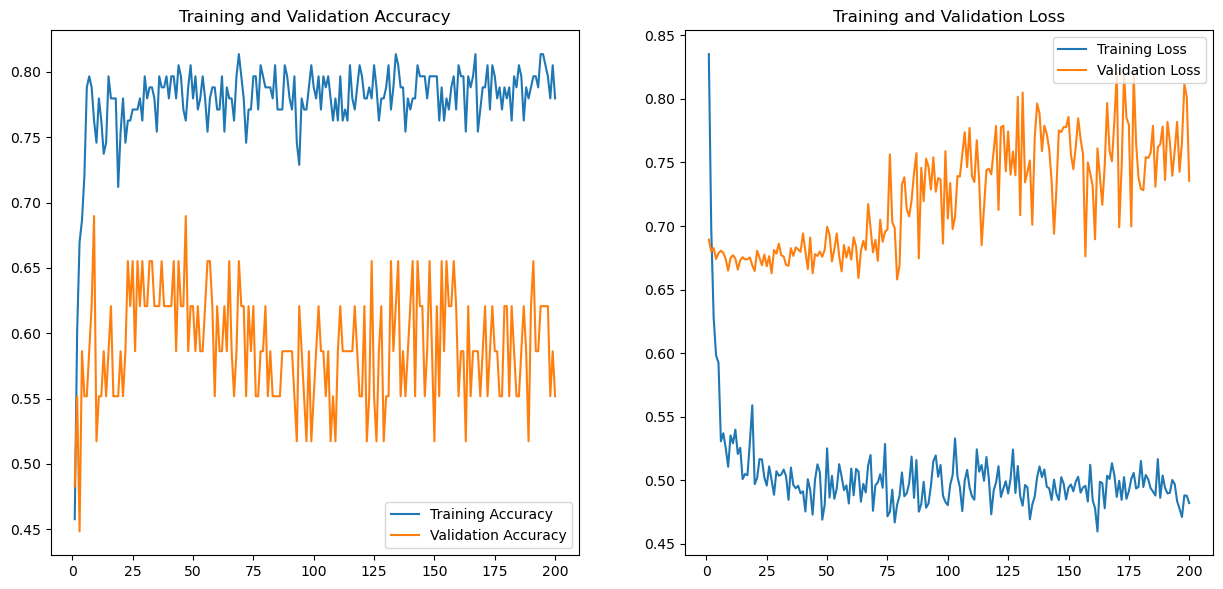

Validation accuracy: 0.586
Epoch 1/200
4/4 [==============================] - 3s 381ms/step - loss: 0.8065 - accuracy: 0.5000 - val_loss: 0.6836 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 189ms/step - loss: 0.6961 - accuracy: 0.6441 - val_loss: 0.6922 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 213ms/step - loss: 0.6350 - accuracy: 0.6864 - val_loss: 0.6922 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5792 - accuracy: 0.7458 - val_loss: 0.6863 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 170ms/step - loss: 0.5748 - accuracy: 0.7203 - val_loss: 0.6874 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 164ms/step - loss: 0.5795 - accuracy: 0.7119 - val_loss: 0.6874 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 7/200
4/4 [==============================] 

Epoch 53/200
4/4 [==============================] - 1s 147ms/step - loss: 0.4879 - accuracy: 0.7542 - val_loss: 0.6977 - val_accuracy: 0.5517 - lr: 1.0000e-06
Epoch 54/200
4/4 [==============================] - 1s 150ms/step - loss: 0.4990 - accuracy: 0.7881 - val_loss: 0.7011 - val_accuracy: 0.5172 - lr: 1.0000e-06
Epoch 55/200
4/4 [==============================] - 1s 153ms/step - loss: 0.4893 - accuracy: 0.7542 - val_loss: 0.6849 - val_accuracy: 0.5862 - lr: 1.0000e-06
Epoch 56/200
4/4 [==============================] - 1s 158ms/step - loss: 0.4801 - accuracy: 0.7881 - val_loss: 0.6888 - val_accuracy: 0.5862 - lr: 1.0000e-06
Epoch 57/200
4/4 [==============================] - 1s 147ms/step - loss: 0.4636 - accuracy: 0.7712 - val_loss: 0.6980 - val_accuracy: 0.5517 - lr: 1.0000e-06
Epoch 58/200
4/4 [==============================] - 1s 152ms/step - loss: 0.4774 - accuracy: 0.7627 - val_loss: 0.7114 - val_accuracy: 0.5862 - lr: 1.0000e-06
Epoch 59/200
4/4 [============================

4/4 [==============================] - 1s 165ms/step - loss: 0.4785 - accuracy: 0.7797 - val_loss: 0.7203 - val_accuracy: 0.5862 - lr: 1.0000e-09
Epoch 105/200
4/4 [==============================] - 1s 155ms/step - loss: 0.4546 - accuracy: 0.7881 - val_loss: 0.7125 - val_accuracy: 0.6207 - lr: 1.0000e-09
Epoch 106/200
4/4 [==============================] - 1s 163ms/step - loss: 0.4802 - accuracy: 0.7542 - val_loss: 0.7414 - val_accuracy: 0.5517 - lr: 1.0000e-09
Epoch 107/200
4/4 [==============================] - 1s 169ms/step - loss: 0.4421 - accuracy: 0.7966 - val_loss: 0.6919 - val_accuracy: 0.6897 - lr: 1.0000e-09
Epoch 108/200
4/4 [==============================] - 1s 167ms/step - loss: 0.4918 - accuracy: 0.7627 - val_loss: 0.6910 - val_accuracy: 0.5862 - lr: 1.0000e-10
Epoch 109/200
4/4 [==============================] - 1s 174ms/step - loss: 0.4824 - accuracy: 0.7797 - val_loss: 0.7086 - val_accuracy: 0.5517 - lr: 1.0000e-10
Epoch 110/200
4/4 [==============================] - 1

4/4 [==============================] - 1s 176ms/step - loss: 0.4792 - accuracy: 0.7797 - val_loss: 0.7162 - val_accuracy: 0.6207 - lr: 1.0000e-14
Epoch 156/200
4/4 [==============================] - 1s 171ms/step - loss: 0.4934 - accuracy: 0.7542 - val_loss: 0.7419 - val_accuracy: 0.4828 - lr: 1.0000e-14
Epoch 157/200
4/4 [==============================] - 1s 152ms/step - loss: 0.4785 - accuracy: 0.7458 - val_loss: 0.8085 - val_accuracy: 0.5172 - lr: 1.0000e-14
Epoch 158/200
4/4 [==============================] - 1s 174ms/step - loss: 0.4771 - accuracy: 0.7797 - val_loss: 0.7074 - val_accuracy: 0.6207 - lr: 1.0000e-14
Epoch 159/200
4/4 [==============================] - 1s 182ms/step - loss: 0.4893 - accuracy: 0.7881 - val_loss: 0.7192 - val_accuracy: 0.5862 - lr: 1.0000e-14
Epoch 160/200
4/4 [==============================] - 1s 153ms/step - loss: 0.4564 - accuracy: 0.8051 - val_loss: 0.7134 - val_accuracy: 0.5517 - lr: 1.0000e-14
Epoch 161/200
4/4 [==============================] - 1

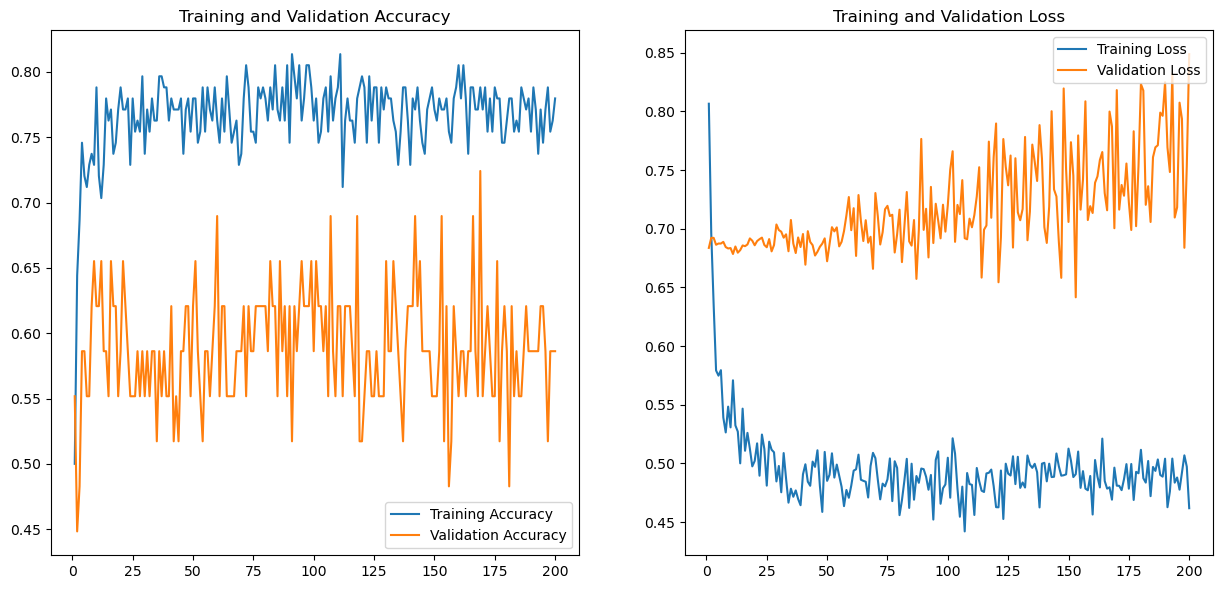

Validation accuracy: 0.621
Epoch 1/200
4/4 [==============================] - 2s 313ms/step - loss: 0.6955 - accuracy: 0.5169 - val_loss: 0.6973 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 170ms/step - loss: 0.6559 - accuracy: 0.5763 - val_loss: 0.6936 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 168ms/step - loss: 0.6203 - accuracy: 0.6441 - val_loss: 0.6930 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 167ms/step - loss: 0.6066 - accuracy: 0.6864 - val_loss: 0.6891 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 156ms/step - loss: 0.5550 - accuracy: 0.7203 - val_loss: 0.6889 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 158ms/step - loss: 0.5544 - accuracy: 0.7288 - val_loss: 0.6834 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 7/200
4/4 [==============================] 

Epoch 53/200
4/4 [==============================] - 1s 153ms/step - loss: 0.4802 - accuracy: 0.7966 - val_loss: 0.7421 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/200
4/4 [==============================] - 1s 165ms/step - loss: 0.4944 - accuracy: 0.7712 - val_loss: 0.7418 - val_accuracy: 0.4828 - lr: 1.0000e-07
Epoch 55/200
4/4 [==============================] - 1s 167ms/step - loss: 0.4951 - accuracy: 0.7881 - val_loss: 0.7412 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 56/200
4/4 [==============================] - 1s 169ms/step - loss: 0.4962 - accuracy: 0.7542 - val_loss: 0.7423 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 57/200
4/4 [==============================] - 1s 162ms/step - loss: 0.4975 - accuracy: 0.7627 - val_loss: 0.7559 - val_accuracy: 0.4828 - lr: 1.0000e-07
Epoch 58/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5180 - accuracy: 0.7627 - val_loss: 0.7455 - val_accuracy: 0.4828 - lr: 1.0000e-07
Epoch 59/200
4/4 [============================

4/4 [==============================] - 1s 153ms/step - loss: 0.5000 - accuracy: 0.7797 - val_loss: 0.7458 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 105/200
4/4 [==============================] - 1s 157ms/step - loss: 0.4890 - accuracy: 0.7881 - val_loss: 0.7447 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 106/200
4/4 [==============================] - 1s 160ms/step - loss: 0.5054 - accuracy: 0.7881 - val_loss: 0.7393 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 107/200
4/4 [==============================] - 1s 159ms/step - loss: 0.5090 - accuracy: 0.7881 - val_loss: 0.7065 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 108/200
4/4 [==============================] - 1s 159ms/step - loss: 0.5223 - accuracy: 0.7627 - val_loss: 0.7279 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 109/200
4/4 [==============================] - 1s 155ms/step - loss: 0.5165 - accuracy: 0.7712 - val_loss: 0.7133 - val_accuracy: 0.6552 - lr: 1.0000e-13
Epoch 110/200
4/4 [==============================] - 1

4/4 [==============================] - 1s 182ms/step - loss: 0.5000 - accuracy: 0.7881 - val_loss: 0.7640 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 156/200
4/4 [==============================] - 1s 166ms/step - loss: 0.5045 - accuracy: 0.7627 - val_loss: 0.7556 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 157/200
4/4 [==============================] - 1s 169ms/step - loss: 0.5016 - accuracy: 0.7712 - val_loss: 0.7391 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 158/200
4/4 [==============================] - 1s 167ms/step - loss: 0.4900 - accuracy: 0.7797 - val_loss: 0.7643 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 159/200
4/4 [==============================] - 1s 172ms/step - loss: 0.4996 - accuracy: 0.7627 - val_loss: 0.7371 - val_accuracy: 0.5517 - lr: 1.0000e-18
Epoch 160/200
4/4 [==============================] - 1s 169ms/step - loss: 0.4986 - accuracy: 0.7712 - val_loss: 0.7359 - val_accuracy: 0.5862 - lr: 1.0000e-18
Epoch 161/200
4/4 [==============================] - 1

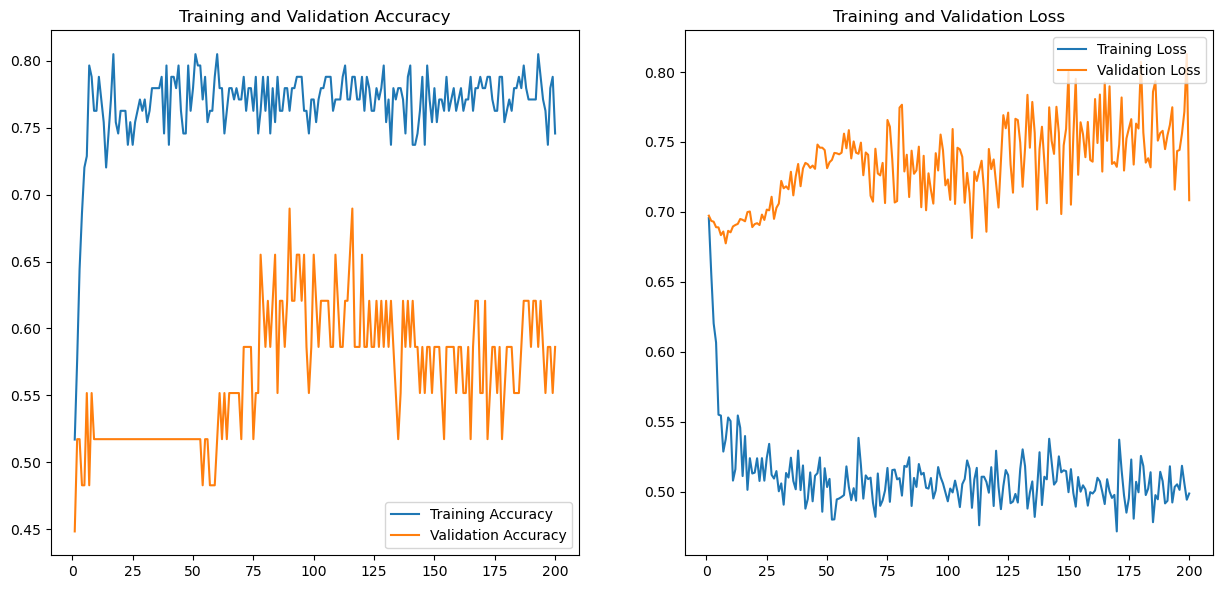

Validation accuracy: 0.552
Epoch 1/200
4/4 [==============================] - 2s 292ms/step - loss: 0.7307 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 165ms/step - loss: 0.6541 - accuracy: 0.6610 - val_loss: 0.6917 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 160ms/step - loss: 0.6482 - accuracy: 0.6271 - val_loss: 0.6923 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 156ms/step - loss: 0.6354 - accuracy: 0.6780 - val_loss: 0.6931 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 145ms/step - loss: 0.5961 - accuracy: 0.6864 - val_loss: 0.6888 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 150ms/step - loss: 0.6004 - accuracy: 0.6864 - val_loss: 0.6893 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/200
4/4 [==============================] 

Epoch 53/200
4/4 [==============================] - 1s 185ms/step - loss: 0.4967 - accuracy: 0.7627 - val_loss: 0.7952 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5094 - accuracy: 0.7797 - val_loss: 0.7936 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/200
4/4 [==============================] - 1s 200ms/step - loss: 0.5193 - accuracy: 0.6864 - val_loss: 0.7890 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 56/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5197 - accuracy: 0.7797 - val_loss: 0.8005 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 57/200
4/4 [==============================] - 1s 194ms/step - loss: 0.4992 - accuracy: 0.7966 - val_loss: 0.8025 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 58/200
4/4 [==============================] - 1s 180ms/step - loss: 0.5139 - accuracy: 0.7712 - val_loss: 0.8050 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/200
4/4 [============================

4/4 [==============================] - 1s 172ms/step - loss: 0.5004 - accuracy: 0.7373 - val_loss: 0.7779 - val_accuracy: 0.5517 - lr: 1.0000e-12
Epoch 105/200
4/4 [==============================] - 1s 188ms/step - loss: 0.5286 - accuracy: 0.7458 - val_loss: 0.7952 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 106/200
4/4 [==============================] - 1s 178ms/step - loss: 0.5041 - accuracy: 0.7542 - val_loss: 0.7898 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 107/200
4/4 [==============================] - 1s 151ms/step - loss: 0.5111 - accuracy: 0.7458 - val_loss: 0.7753 - val_accuracy: 0.5517 - lr: 1.0000e-12
Epoch 108/200
4/4 [==============================] - 1s 157ms/step - loss: 0.5070 - accuracy: 0.7712 - val_loss: 0.7767 - val_accuracy: 0.5517 - lr: 1.0000e-13
Epoch 109/200
4/4 [==============================] - 1s 152ms/step - loss: 0.5022 - accuracy: 0.7712 - val_loss: 0.7679 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 110/200
4/4 [==============================] - 1

4/4 [==============================] - 1s 167ms/step - loss: 0.4956 - accuracy: 0.7881 - val_loss: 0.7336 - val_accuracy: 0.6207 - lr: 1.0000e-17
Epoch 156/200
4/4 [==============================] - 1s 158ms/step - loss: 0.5225 - accuracy: 0.7119 - val_loss: 0.7184 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 157/200
4/4 [==============================] - 1s 150ms/step - loss: 0.4841 - accuracy: 0.7712 - val_loss: 0.7038 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 158/200
4/4 [==============================] - 1s 152ms/step - loss: 0.4732 - accuracy: 0.7712 - val_loss: 0.7550 - val_accuracy: 0.5862 - lr: 1.0000e-18
Epoch 159/200
4/4 [==============================] - 1s 155ms/step - loss: 0.4946 - accuracy: 0.7288 - val_loss: 0.7107 - val_accuracy: 0.6207 - lr: 1.0000e-18
Epoch 160/200
4/4 [==============================] - 1s 152ms/step - loss: 0.5204 - accuracy: 0.7203 - val_loss: 0.7019 - val_accuracy: 0.5517 - lr: 1.0000e-18
Epoch 161/200
4/4 [==============================] - 1

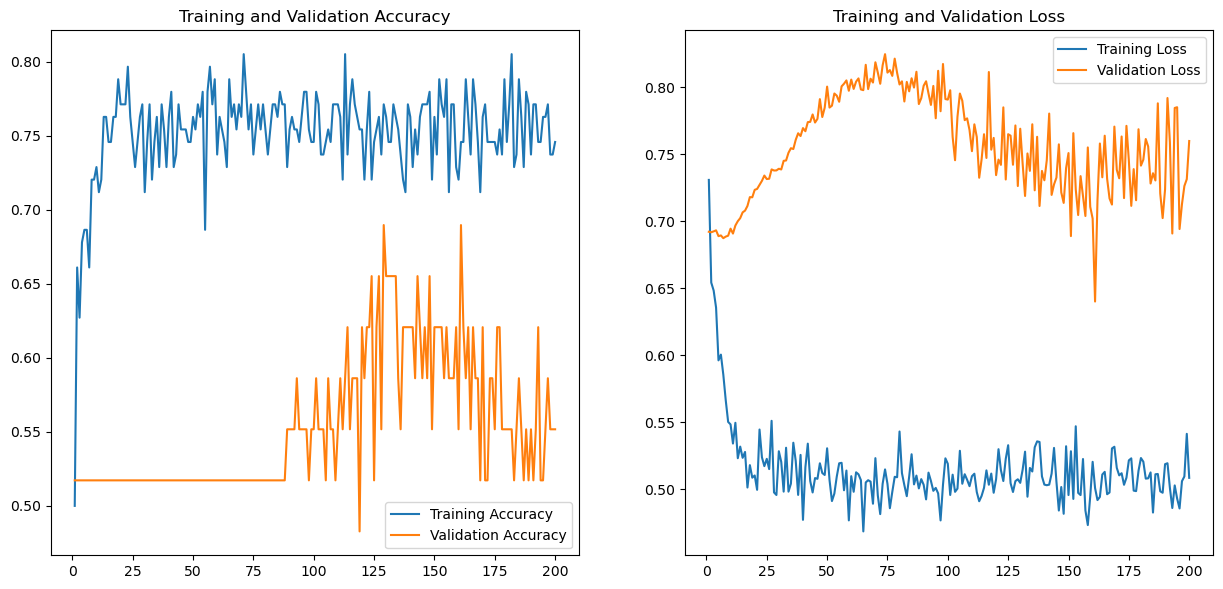

Validation accuracy: 0.552
Epoch 1/200
4/4 [==============================] - 3s 317ms/step - loss: 0.6378 - accuracy: 0.6441 - val_loss: 0.6994 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 166ms/step - loss: 0.6230 - accuracy: 0.6271 - val_loss: 0.7013 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 165ms/step - loss: 0.5960 - accuracy: 0.6695 - val_loss: 0.7057 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 165ms/step - loss: 0.5583 - accuracy: 0.7034 - val_loss: 0.6981 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 168ms/step - loss: 0.5470 - accuracy: 0.7288 - val_loss: 0.6935 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 167ms/step - loss: 0.5400 - accuracy: 0.7542 - val_loss: 0.6866 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/200
4/4 [==============================] 

Epoch 53/200
4/4 [==============================] - 1s 156ms/step - loss: 0.4814 - accuracy: 0.7797 - val_loss: 0.7486 - val_accuracy: 0.5517 - lr: 1.0000e-07
Epoch 54/200
4/4 [==============================] - 1s 149ms/step - loss: 0.4720 - accuracy: 0.8220 - val_loss: 0.7541 - val_accuracy: 0.5517 - lr: 1.0000e-07
Epoch 55/200
4/4 [==============================] - 1s 150ms/step - loss: 0.4954 - accuracy: 0.7288 - val_loss: 0.7397 - val_accuracy: 0.5517 - lr: 1.0000e-07
Epoch 56/200
4/4 [==============================] - 1s 149ms/step - loss: 0.4646 - accuracy: 0.7712 - val_loss: 0.7405 - val_accuracy: 0.6207 - lr: 1.0000e-07
Epoch 57/200
4/4 [==============================] - 1s 148ms/step - loss: 0.4682 - accuracy: 0.7797 - val_loss: 0.7342 - val_accuracy: 0.5862 - lr: 1.0000e-07
Epoch 58/200
4/4 [==============================] - 1s 153ms/step - loss: 0.4951 - accuracy: 0.7712 - val_loss: 0.7485 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 59/200
4/4 [============================

4/4 [==============================] - 1s 166ms/step - loss: 0.4955 - accuracy: 0.7627 - val_loss: 0.7757 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 105/200
4/4 [==============================] - 1s 157ms/step - loss: 0.4627 - accuracy: 0.8051 - val_loss: 0.7628 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 106/200
4/4 [==============================] - 1s 152ms/step - loss: 0.4630 - accuracy: 0.7881 - val_loss: 0.7825 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 107/200
4/4 [==============================] - 1s 169ms/step - loss: 0.4761 - accuracy: 0.7881 - val_loss: 0.7521 - val_accuracy: 0.6552 - lr: 1.0000e-12
Epoch 108/200
4/4 [==============================] - 1s 162ms/step - loss: 0.4607 - accuracy: 0.7881 - val_loss: 0.7884 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 109/200
4/4 [==============================] - 1s 160ms/step - loss: 0.4875 - accuracy: 0.7797 - val_loss: 0.7821 - val_accuracy: 0.5517 - lr: 1.0000e-12
Epoch 110/200
4/4 [==============================] - 1

4/4 [==============================] - 1s 143ms/step - loss: 0.4745 - accuracy: 0.7881 - val_loss: 0.7584 - val_accuracy: 0.5517 - lr: 1.0000e-17
Epoch 156/200
4/4 [==============================] - 1s 149ms/step - loss: 0.4771 - accuracy: 0.7881 - val_loss: 0.7671 - val_accuracy: 0.5517 - lr: 1.0000e-17
Epoch 157/200
4/4 [==============================] - 1s 146ms/step - loss: 0.4768 - accuracy: 0.7966 - val_loss: 0.8355 - val_accuracy: 0.5517 - lr: 1.0000e-17
Epoch 158/200
4/4 [==============================] - 1s 148ms/step - loss: 0.4878 - accuracy: 0.7881 - val_loss: 0.7768 - val_accuracy: 0.6207 - lr: 1.0000e-17
Epoch 159/200
4/4 [==============================] - 1s 149ms/step - loss: 0.4784 - accuracy: 0.7966 - val_loss: 0.8033 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 160/200
4/4 [==============================] - 1s 146ms/step - loss: 0.4911 - accuracy: 0.7797 - val_loss: 0.8250 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 161/200
4/4 [==============================] - 1

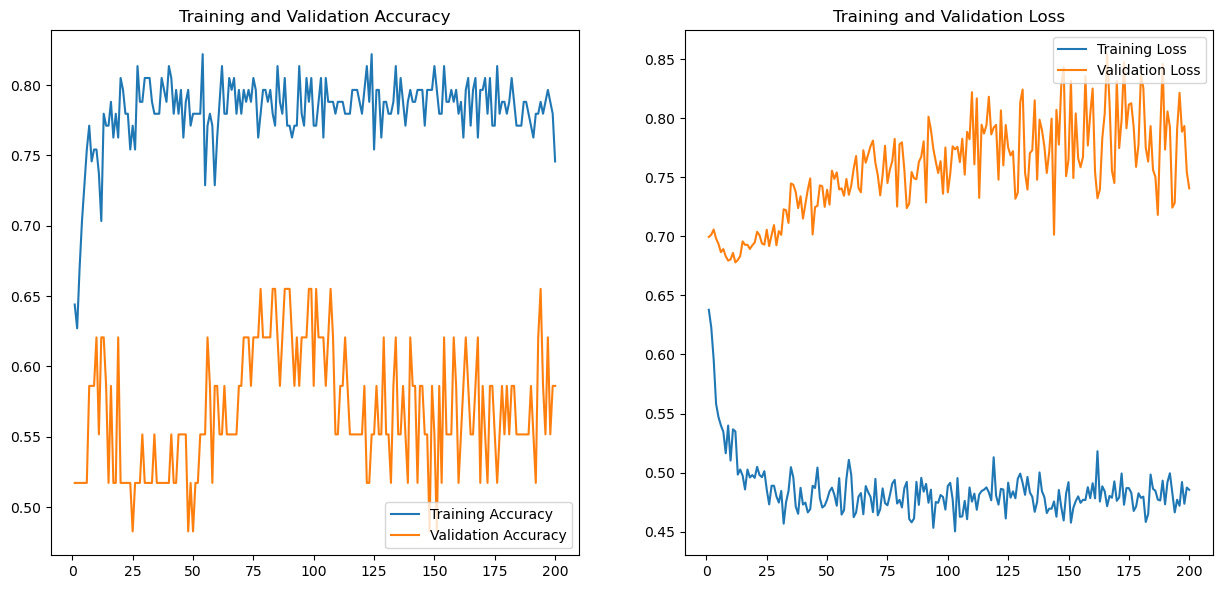

Validation accuracy: 0.586


In [19]:
batch_size = 42
acc_f_aug = []

for i in range(10):
    model_f_aug = cnn_f_aug()
    learning_rate = 0.001
    model_f_aug.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy']) 
    train_f_aug = model_f_aug.fit(aug_train_f,
                            batch_size = batch_size,
                            epochs = 200,
                            verbose = 1,
                            validation_data = aug_val_f,
                            callbacks = [reduce_on_plateau])
    acc = train_f_aug.history['accuracy']
    val_acc = train_f_aug.history['val_accuracy']
    loss = train_f_aug.history['loss']
    val_loss = train_f_aug.history['val_loss']
    
    epochs_range = range(1, len(acc)+1)
    #Train and validation accuracy 
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    #Train and validation loss 
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    _, val_acc = model_f_aug.evaluate(aug_val_f, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_f_aug.append(val_acc)

In [20]:
media_f_aug = np.mean(acc_f_aug)
std_f_aug = np.std(acc_f_aug)
print(media_f_aug)
print(std_f_aug)

0.5827586233615876
0.024137925250194148


In [ ]:
eng.quit()